In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

project_path = '/content/drive/My Drive/Project Heart Risk Classification files/Heart MRI Code'
# os.chdir(project_path) # Removed as it's not necessary for the notebook to run

print("Current working directory:", os.getcwd())

Current working directory: /content


In [ ]:
!ls

drive  sample_data


In [ ]:
#DATASET
from google.colab import files
uploaded = files.upload()
import zipfile
zip_path = "emidec_data.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("dataset")

Saving emidec_data.zip to emidec_data.zip


In [ ]:
#MASK UPLOAD
from google.colab import files
uploaded = files.upload()
import zipfile
zip_path = "predicted1_masks.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("predicted1_masks")

Saving predicted1_masks.zip to predicted1_masks (1).zip


In [ ]:
#GROUND TRUTH
import os
import re
import pandas as pd

# --- Configuration ---

# 1. List of paths to the folders containing your patient .txt files
DATASET_FOLDER_PATHS = [
    '/content/dataset/emidec-data/emidec-dataset-1.0.1/Text data',
    '/content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Text Data'
]

# 2. Output file name for the combined results
OUTPUT_CSV_FILE = 'combined_patient_risk_classification.csv'

# --- Helper Functions (No changes needed here) ---

def parse_patient_info(file_path):
    """
    Reads a patient's .txt file and extracts key clinical parameters.
    """
    # Initialize dictionary with None to handle missing values gracefully
    patient_info = {'LVEF': None, 'Troponin': None, 'NTProBNP': None, 'Age': None}
    encodings_to_try = ['utf-8', 'latin-1', 'cp1252']
    content = None

    for encoding in encodings_to_try:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                content = f.read()
            break
        except Exception:
            continue

    if content is None:
        print(f"  ❌ Error: Could not decode file {os.path.basename(file_path)}.")
        return None

    keys_to_find = {'FEVG': 'LVEF', 'LVEF': 'LVEF', 'Troponin': 'Troponin', 'NTProBNP': 'NTProBNP', 'Age': 'Age'}

    for search_key, final_key in keys_to_find.items():
        match = re.search(rf"{re.escape(search_key)}\s*:\s*(.+)", content, re.IGNORECASE)
        if match:
            value = match.group(1).strip()
            numeric_match = re.search(r'(\d+\.?\d*)', value)
            if numeric_match:
                patient_info[final_key] = float(numeric_match.group(1))

    return patient_info

def classify_patient_risk(info):
    """
    Classifies a patient into a risk category and provides the reasoning.
    Returns a tuple: (Risk_Category, Reason)
    """
    troponin = info.get('Troponin', 0)
    lvef = info.get('LVEF', 100)
    ntprobnp = info.get('NTProBNP', 0)
    age = info.get('Age', 50)

    troponin_ng_L = troponin * 1000 if troponin < 10 else troponin
    if troponin_ng_L > 50:
        reason = f"Acutely elevated Troponin ({troponin}) indicates myocardial injury."
        return 'Very High Risk (Acute Cardiac Event)', reason

    if lvef is not None and lvef <= 40:
        reason = f"LVEF is {lvef} (<= 40%), indicating severely reduced function."
        return 'High Risk (Chronic Heart Failure)', reason

    is_high_ntprobnp = False
    if age > 75 and ntprobnp > 1800: is_high_ntprobnp = True
    elif age >= 50 and ntprobnp > 900: is_high_ntprobnp = True
    elif age < 50 and ntprobnp > 450: is_high_ntprobnp = True
    if is_high_ntprobnp:
        reason = f"NT-proBNP of {ntprobnp} is very high for age {age}, indicating severe heart stress."
        return 'High Risk (Chronic Heart Failure)', reason

    if lvef is not None and 41 <= lvef <= 54:
        reason = f"LVEF is {lvef} (41-54%), indicating mildly reduced function."
        return 'Moderate Risk', reason

    is_moderate_ntprobnp = False
    if age > 75 and 125 < ntprobnp <= 1800: is_moderate_ntprobnp = True
    elif age >= 50 and 125 < ntprobnp <= 900: is_moderate_ntprobnp = True
    elif age < 50 and 125 < ntprobnp <= 450: is_moderate_ntprobnp = True
    if is_moderate_ntprobnp:
        reason = f"NT-proBNP of {ntprobnp} is moderately elevated for age {age}."
        return 'Moderate Risk', reason

    reason = f"LVEF ({lvef}), Troponin ({troponin}), and NT-proBNP ({ntprobnp}) are all within normal limits for age {age}."
    return 'Low Risk', reason

# --- Main Execution ---

all_patient_classifications = []

for folder_path in DATASET_FOLDER_PATHS:
    print(f"\n▶️ Starting classification for patients in: {folder_path}")

    if not os.path.isdir(folder_path):
        print(f"  ❌ WARNING: The directory was not found. Skipping.")
        continue

    patient_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.txt')])

    for file_name in patient_files:
        full_file_path = os.path.join(folder_path, file_name)

        # --- MODIFIED LINE ---
        # This new regex finds the first number in the filename, which is more robust.
        # It handles 'Case P001.txt', 'N001.txt', and 'Case 101.txt' correctly.
        match = re.search(r'(\d+)', file_name)

        if not match:
            print(f"  ⚠️ Could not extract a numeric Patient ID from '{file_name}'. Skipping.")
            continue
        patient_id = match.group(1) # Group 1 contains the number (e.g., '101')

        patient_info = parse_patient_info(full_file_path)

        if patient_info and patient_info.get('LVEF') is not None:
            risk_category, reason = classify_patient_risk(patient_info)

            risk_score_map = {
                'Very High Risk (Acute Cardiac Event)': 3,
                'High Risk (Chronic Heart Failure)': 2,
                'Moderate Risk': 1,
                'Low Risk': 0
            }
            risk_score = risk_score_map.get(risk_category, -1)

            all_patient_classifications.append({
                'PatientID': patient_id,
                'Age': patient_info.get('Age'),
                'LVEF': patient_info.get('LVEF'),
                'Troponin': patient_info.get('Troponin'),
                'NTProBNP': patient_info.get('NTProBNP'),
                'Risk_Category': risk_category,
                'Risk_Score': risk_score,
                'Reasoning': reason
            })

# --- Final Output Generation ---
if all_patient_classifications:
    results_df = pd.DataFrame(all_patient_classifications)
    column_order = ['PatientID', 'Risk_Category', 'Risk_Score', 'Reasoning', 'Age', 'LVEF', 'Troponin', 'NTProBNP']
    results_df = results_df[column_order]
    results_df.drop_duplicates(subset='PatientID', keep='first', inplace=True)
    results_df.to_csv(OUTPUT_CSV_FILE, index=False)

    print(f"\n✅ Processing complete. Combined data for {len(results_df)} patients saved to '{OUTPUT_CSV_FILE}'.")
    print("\n--- Result Preview ---")
    print(results_df.head())
    print("\n--- Combined Risk Category Distribution ---")
    print(results_df['Risk_Category'].value_counts())
else:
    print("\nNo processable patient data was found in any of the specified directories.")


▶️ Starting classification for patients in: /content/dataset/emidec-data/emidec-dataset-1.0.1/Text data

▶️ Starting classification for patients in: /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Text Data

✅ Processing complete. Combined data for 150 patients saved to 'combined_patient_risk_classification.csv'.

--- Result Preview ---
  PatientID                         Risk_Category  Risk_Score  \
0       006  Very High Risk (Acute Cardiac Event)           3   
1       012  Very High Risk (Acute Cardiac Event)           3   
2       013  Very High Risk (Acute Cardiac Event)           3   
3       014  Very High Risk (Acute Cardiac Event)           3   
4       016                         Moderate Risk           1   

                                           Reasoning   Age  LVEF  Troponin  \
0  Acutely elevated Troponin (1.1) indicates myoc...  70.0  60.0      1.10   
1  Acutely elevated Troponin (2.8) indicates myoc...  33.0  60.0      2.80   
2  Acutely elev

In [ ]:
# 1. First, upgrade pip and install the necessary build tools
!pip install --upgrade pip
!pip install wheel numpy cython

# 2. Next, install pyradiomics directly from its official source repository
!pip install git+https://github.com/AIM-Harvard/pyradiomics.git

# 3. Finally, install the remaining packages
!pip install SimpleITK nibabel pytorchvideo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Cloning https://github.com/AIM-Harvard/pyradiomics.git to /tmp/pip-req-build-y9kodo2p
  Running command git clone --filter=blob:none --quiet https://github.com/AIM-Harvard/pyradiomics.git /tmp/pip-req-build-y9kodo2p
  Resolved https://github.com/AIM-Harvard/pyradiomics.git to commit 8ed579383b44806651c463d5e691f3b2b57522ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 22.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 49.7 

In [ ]:
!pip install torch torchvision torchaudio
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 11.3 MB/s  0:00:00


In [ ]:
#U NET MODEL MASKING
import os
import numpy as np
import nibabel as nib
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# ---------------------------
# Helper Functions
# ---------------------------
def load_nii(path):
    nii = nib.load(path)
    return nii.get_fdata()

def normalize_img(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)

def preprocess_volume(img, mask=None, target_size=(128,128)):
    slices, masks = [], []
    for i in range(img.shape[2]):
        slice_img = normalize_img(img[:,:,i])
        slice_img = tf.image.resize(slice_img[...,None], target_size).numpy()
        slices.append(slice_img)

        if mask is not None:
            slice_mask = mask[:,:,i]
            # Ensure mask values are within expected range (0, 1, or 2)
            slice_mask[slice_mask > 2] = 0 # Set values greater than 2 to 0 (background)
            slice_mask = tf.image.resize(slice_mask[...,None], target_size, method="nearest").numpy()
            masks.append(slice_mask)
    if mask is not None:
        return np.array(slices), np.array(masks)
    return np.array(slices)

# ---------------------------
# Multi-class U-Net Model
# ---------------------------
def unet_multiclass(input_shape=(128,128,1), num_classes=3):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    bn = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    bn = layers.Conv2D(128, (3,3), activation='relu', padding='same')(bn)

    # Decoder
    u1 = layers.UpSampling2D((2,2))(bn)
    u1 = layers.concatenate([u1, c3])
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c4)

    u2 = layers.UpSampling2D((2,2))(c4)
    u2 = layers.concatenate([u2, c2])
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2,2))(c5)
    u3 = layers.concatenate([u3, c1])
    c6 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c6)

    outputs = layers.Conv2D(num_classes, (1,1), activation='softmax')(c6)

    model = models.Model(inputs, outputs)
    return model

# ---------------------------
# Load Training Data
# ---------------------------
TRAIN_DATA_PATH = '/content/dataset/emidec-data/emidec-dataset-1.0.1/Data'
# Corrected glob patterns to match the extracted dataset structure
img_paths = sorted(glob(os.path.join(TRAIN_DATA_PATH, "Case_*", "Images", "*.nii.gz")))
mask_paths = sorted(glob(os.path.join(TRAIN_DATA_PATH, "Case_*", "Contours", "*.nii.gz")))

X, Y = [], []
for img_p, mask_p in zip(img_paths, mask_paths):
    img = load_nii(img_p)
    mask = load_nii(mask_p)  # Expected mask with labels {0,1,2}
    xs, ys = preprocess_volume(img, mask)
    X.append(xs); Y.append(ys)

X = np.concatenate(X, axis=0)
Y = np.concatenate(Y, axis=0)

# One-hot encode masks
Y = tf.keras.utils.to_categorical(Y, num_classes=3)

# Split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# ---------------------------
# Train Model
# ---------------------------
model = unet_multiclass()
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=40, batch_size=16,
                    validation_data=(X_val, Y_val))

# Save for inference
model.save("/content/unet_multiclass.h5")
print("✅ Model saved as /content/unet_multiclass.h5")

Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9673 - loss: 0.4706 - val_accuracy: 0.9709 - val_loss: 0.1171
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9724 - loss: 0.1048 - val_accuracy: 0.9709 - val_loss: 0.0965
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9727 - loss: 0.0871 - val_accuracy: 0.9709 - val_loss: 0.0805
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9727 - loss: 0.0750 - val_accuracy: 0.9709 - val_loss: 0.0758
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.9732 - loss: 0.0709 - val_accuracy: 0.9709 - val_loss: 0.0697
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9726 - loss: 0.0663 - val_accuracy: 0.9709 - val_loss: 0.0655
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9719 - loss: 0.0641 - val_accuracy: 0.9709 - val_loss: 0.0645
Epoch 8/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.9721 - loss: 0.0624 - val_accuracy: 0.9709 - va

✅ Model saved as /content/unet_multiclass.h5


In [ ]:
#PREPROCESSING MASKS
import os
import re
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import SimpleITK as sitk
from skimage.measure import label
from tqdm import tqdm
import sys

# ================================
# PATHS
# ================================
TEST_DATA_PATH = '/content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data'
SAVE_PATH = '/content/predicted_masks'
os.makedirs(SAVE_PATH, exist_ok=True)

# ================================
# LOAD MODEL
# ================================
MODEL_PATH = "/content/unet_multiclass.h5"
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

# ================================
# HELPERS
# ================================
def preprocess_volume_for_prediction(img_volume, target_size=(128,128)):
    """Normalize & resize slices for prediction."""
    slices = []
    for i in range(img_volume.shape[2]):
        slice_img = img_volume[:,:,i]
        slice_norm = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img) + 1e-8)
        slice_resized = tf.image.resize(slice_norm[...,None], target_size, method='bilinear').numpy()
        slices.append(slice_resized)
    return np.array(slices)

def post_process_mask(mask_array):
    """Keep only the largest connected component."""
    labels = label(mask_array)
    if labels.max() == 0:
        return mask_array
    largest_cc = labels == np.argmax(np.bincount(labels.flat)[1:]) + 1
    return largest_cc.astype(np.uint8)

def save_mask_nifti(mask_volume, reference_image_path, output_dir):
    """Save 3D predicted mask as NIfTI file aligned to original image."""
    itk_img = sitk.ReadImage(reference_image_path)
    mask_itk = sitk.GetImageFromArray(np.transpose(mask_volume, (2,1,0)))  # back to Z,Y,X
    mask_itk.CopyInformation(itk_img)

    patient_id = re.search(r'Case_([PN]?\d+)', reference_image_path).group(1)
    output_path = os.path.join(output_dir, f"{patient_id}_predmask.nii.gz")
    sitk.WriteImage(mask_itk, output_path)
    print(f"    Saved 3D NIfTI mask → {output_path}", file=sys.stdout, flush=True)

def save_mask_slice_as_png(mask_volume, original_image_path, output_dir):
    """Save middle slice of predicted mask as PNG."""
    middle_slice_index = mask_volume.shape[2] // 2
    mask_slice = mask_volume[:, :, middle_slice_index]

    patient_id = re.search(r'Case_([PN]?\d+)', original_image_path).group(1)
    output_path = os.path.join(output_dir, f"{patient_id}_predmask_slice.png")

    plt.figure(figsize=(6, 6))
    plt.imshow(mask_slice, cmap='gray')
    plt.title(f"Patient {patient_id} Predicted Myocardium Mask")
    plt.axis('off')
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"    Saved mask PNG → {output_path}", file=sys.stdout, flush=True)

def save_mri_and_mask_overlay(img_array, mask_volume, original_image_path, output_dir):
    """Save side-by-side MRI and overlay mask as PNG."""
    middle_slice_index = img_array.shape[2] // 2
    mri_slice = img_array[:, :, middle_slice_index]
    mask_slice = mask_volume[:, :, middle_slice_index]

    patient_id = re.search(r'Case_([PN]?\d+)', original_image_path).group(1)
    output_path = os.path.join(output_dir, f"{patient_id}_mri_mask_overlay.png")

    plt.figure(figsize=(10,5))
    # Left: MRI
    plt.subplot(1,2,1)
    plt.imshow(mri_slice, cmap='gray')
    plt.title("MRI")
    plt.axis('off')

    # Right: Overlay
    plt.subplot(1,2,2)
    plt.imshow(mri_slice, cmap='gray')
    plt.imshow(mask_slice, cmap='Reds', alpha=0.5)
    plt.title("Predicted LV Myocardium")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"    Saved MRI+Mask overlay → {output_path}", file=sys.stdout, flush=True)

# ================================
# MAIN PREDICTION PIPELINE
# ================================
def predict_and_save_mask(image_path, model, output_dir, target_size=(128,128)):
    try:
        # Load MRI
        img_itk = sitk.ReadImage(image_path)
        img_array = sitk.GetArrayFromImage(img_itk)  # Z,Y,X
        img_array = np.transpose(img_array, (2,1,0)) # X,Y,Z

        # Preprocess & predict
        preprocessed_slices = preprocess_volume_for_prediction(img_array, target_size)
        preprocessed_slices = preprocessed_slices[..., np.newaxis]
        predictions = model.predict(preprocessed_slices)

        # Handle class count
        num_classes = predictions.shape[-1]
        if num_classes == 3:
            myocardium_prob = predictions[:, :, :, 2]
        elif num_classes == 2:
            myocardium_prob = predictions[:, :, :, 1]
        else:
            print(f"⚠️ Unexpected class count {num_classes} in model output.")
            return

        myocardium_mask_resized = (myocardium_prob > 0.5).astype(np.uint8)

        # Post-process
        cleaned_mask_resized = np.zeros_like(myocardium_mask_resized)
        for i in range(cleaned_mask_resized.shape[0]):
            cleaned_mask_resized[i, :, :] = post_process_mask(myocardium_mask_resized[i, :, :])

        # Resize back to original
        original_dims = (img_array.shape[0], img_array.shape[1])
        cleaned_mask_original_size = np.zeros_like(img_array, dtype=np.uint8)
        for i in range(cleaned_mask_original_size.shape[2]):
            resized_slice = tf.image.resize(cleaned_mask_resized[i, ..., None], original_dims, method="nearest").numpy().squeeze()
            cleaned_mask_original_size[:, :, i] = resized_slice

        # ✅ Save outputs
        save_mask_nifti(cleaned_mask_original_size, image_path, output_dir)
        save_mask_slice_as_png(cleaned_mask_original_size, image_path, output_dir)
        save_mri_and_mask_overlay(img_array, cleaned_mask_original_size, image_path, output_dir)

    except Exception as e:
        print(f"❌ Error {os.path.basename(image_path)}: {e}", file=sys.stdout, flush=True)

# ================================
# RUN FOR ALL TEST CASES
# ================================
test_image_files = sorted(glob(os.path.join(TEST_DATA_PATH, "Case_*", "Images", "*.nii.gz")))
if not test_image_files:
    print(f"❌ No test images found in {TEST_DATA_PATH}")
else:
    print(f"Found {len(test_image_files)} test cases")
    for image_path in tqdm(test_image_files, desc="Predicting Masks"):
        predict_and_save_mask(image_path, model, SAVE_PATH)

print(f"\n✅ All predictions done. NIfTI + PNGs saved in {SAVE_PATH}")


Found 50 test cases


Predicting Masks:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/101_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/101_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/101_mri_mask_overlay.png


Predicting Masks:   2%|▏         | 1/50 [00:01<01:15,  1.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/102_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/102_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/102_mri_mask_overlay.png


Predicting Masks:   4%|▍         | 2/50 [00:03<01:25,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/103_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/103_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/103_mri_mask_overlay.png


Predicting Masks:   6%|▌         | 3/50 [00:04<01:16,  1.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/104_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/104_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/104_mri_mask_overlay.png


Predicting Masks:   8%|▊         | 4/50 [00:05<01:02,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/105_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/105_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/105_mri_mask_overlay.png


Predicting Masks:  10%|█         | 5/50 [00:07<01:00,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/106_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/106_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/106_mri_mask_overlay.png


Predicting Masks:  12%|█▏        | 6/50 [00:08<00:51,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/107_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/107_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/107_mri_mask_overlay.png


Predicting Masks:  14%|█▍        | 7/50 [00:08<00:47,  1.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/108_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/108_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/108_mri_mask_overlay.png


Predicting Masks:  16%|█▌        | 8/50 [00:10<00:56,  1.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/109_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/109_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/109_mri_mask_overlay.png


Predicting Masks:  18%|█▊        | 9/50 [00:11<00:51,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/110_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/110_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/110_mri_mask_overlay.png


Predicting Masks:  20%|██        | 10/50 [00:13<00:49,  1.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/111_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/111_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/111_mri_mask_overlay.png


Predicting Masks:  22%|██▏       | 11/50 [00:14<00:45,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/112_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/112_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/112_mri_mask_overlay.png


Predicting Masks:  24%|██▍       | 12/50 [00:15<00:44,  1.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/113_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/113_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/113_mri_mask_overlay.png


Predicting Masks:  26%|██▌       | 13/50 [00:17<00:50,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/114_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/114_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/114_mri_mask_overlay.png


Predicting Masks:  28%|██▊       | 14/50 [00:18<00:49,  1.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/115_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/115_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/115_mri_mask_overlay.png


Predicting Masks:  30%|███       | 15/50 [00:19<00:47,  1.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/116_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/116_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/116_mri_mask_overlay.png


Predicting Masks:  32%|███▏      | 16/50 [00:20<00:41,  1.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/117_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/117_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/117_mri_mask_overlay.png


Predicting Masks:  34%|███▍      | 17/50 [00:21<00:36,  1.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/118_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/118_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/118_mri_mask_overlay.png


Predicting Masks:  36%|███▌      | 18/50 [00:22<00:34,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/119_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/119_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/119_mri_mask_overlay.png


Predicting Masks:  38%|███▊      | 19/50 [00:23<00:33,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/120_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/120_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/120_mri_mask_overlay.png


Predicting Masks:  40%|████      | 20/50 [00:24<00:29,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/121_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/121_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/121_mri_mask_overlay.png


Predicting Masks:  42%|████▏     | 21/50 [00:25<00:28,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/122_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/122_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/122_mri_mask_overlay.png


Predicting Masks:  44%|████▍     | 22/50 [00:26<00:25,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/123_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/123_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/123_mri_mask_overlay.png


Predicting Masks:  46%|████▌     | 23/50 [00:26<00:23,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/124_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/124_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/124_mri_mask_overlay.png


Predicting Masks:  48%|████▊     | 24/50 [00:27<00:21,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/125_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/125_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/125_mri_mask_overlay.png


Predicting Masks:  50%|█████     | 25/50 [00:28<00:21,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/126_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/126_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/126_mri_mask_overlay.png


Predicting Masks:  52%|█████▏    | 26/50 [00:29<00:23,  1.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/127_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/127_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/127_mri_mask_overlay.png


Predicting Masks:  54%|█████▍    | 27/50 [00:31<00:24,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/128_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/128_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/128_mri_mask_overlay.png


Predicting Masks:  56%|█████▌    | 28/50 [00:32<00:23,  1.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/129_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/129_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/129_mri_mask_overlay.png


Predicting Masks:  58%|█████▊    | 29/50 [00:33<00:22,  1.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/130_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/130_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/130_mri_mask_overlay.png


Predicting Masks:  60%|██████    | 30/50 [00:34<00:21,  1.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/131_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/131_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/131_mri_mask_overlay.png


Predicting Masks:  62%|██████▏   | 31/50 [00:35<00:19,  1.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/132_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/132_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/132_mri_mask_overlay.png


Predicting Masks:  64%|██████▍   | 32/50 [00:36<00:17,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/133_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/133_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/133_mri_mask_overlay.png


Predicting Masks:  66%|██████▌   | 33/50 [00:36<00:15,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/134_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/134_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/134_mri_mask_overlay.png


Predicting Masks:  68%|██████▊   | 34/50 [00:37<00:15,  1.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/135_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/135_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/135_mri_mask_overlay.png


Predicting Masks:  70%|███████   | 35/50 [00:38<00:13,  1.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/136_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/136_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/136_mri_mask_overlay.png


Predicting Masks:  72%|███████▏  | 36/50 [00:39<00:12,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/137_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/137_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/137_mri_mask_overlay.png


Predicting Masks:  74%|███████▍  | 37/50 [00:40<00:11,  1.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/138_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/138_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/138_mri_mask_overlay.png


Predicting Masks:  76%|███████▌  | 38/50 [00:41<00:10,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/139_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/139_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/139_mri_mask_overlay.png


Predicting Masks:  78%|███████▊  | 39/50 [00:42<00:09,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/140_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/140_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/140_mri_mask_overlay.png


Predicting Masks:  80%|████████  | 40/50 [00:43<00:09,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/141_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/141_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/141_mri_mask_overlay.png


Predicting Masks:  82%|████████▏ | 41/50 [00:44<00:09,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/142_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/142_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/142_mri_mask_overlay.png


Predicting Masks:  84%|████████▍ | 42/50 [00:45<00:09,  1.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/143_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/143_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/143_mri_mask_overlay.png


Predicting Masks:  86%|████████▌ | 43/50 [00:47<00:08,  1.17s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/144_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/144_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/144_mri_mask_overlay.png


Predicting Masks:  88%|████████▊ | 44/50 [00:48<00:07,  1.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/145_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/145_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/145_mri_mask_overlay.png


Predicting Masks:  90%|█████████ | 45/50 [00:49<00:05,  1.07s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/146_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/146_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/146_mri_mask_overlay.png


Predicting Masks:  92%|█████████▏| 46/50 [00:50<00:04,  1.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/147_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/147_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/147_mri_mask_overlay.png


Predicting Masks:  94%|█████████▍| 47/50 [00:51<00:02,  1.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/148_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/148_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/148_mri_mask_overlay.png


Predicting Masks:  96%|█████████▌| 48/50 [00:51<00:01,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/149_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/149_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/149_mri_mask_overlay.png


Predicting Masks:  98%|█████████▊| 49/50 [00:52<00:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
    Saved 3D NIfTI mask → /content/predicted_masks/150_predmask.nii.gz
    Saved mask PNG → /content/predicted_masks/150_predmask_slice.png
    Saved MRI+Mask overlay → /content/predicted_masks/150_mri_mask_overlay.png


Predicting Masks: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


✅ All predictions done. NIfTI + PNGs saved in /content/predicted_masks


In [ ]:
import os
import zipfile
from google.colab import files


# Directory to zip
directory_to_zip = '/content/predicted_masks'
# Name for the zip file
zip_filename = 'predicted_masks.zip'

# Create the zip file
try:
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files_in_dir in os.walk(directory_to_zip):
            for file in files_in_dir:
                # Create a relative path for files inside the zip
                arcname = os.path.relpath(os.path.join(root, file), directory_to_zip)
                zipf.write(os.path.join(root, file), arcname)
    print(f"Successfully created {zip_filename}")

    # Download the zip file
    files.download(zip_filename)
    print(f"Downloading {zip_filename}...")

except FileNotFoundError:
    print(f"Error: The directory '{directory_to_zip}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully created predicted_masks.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#RADIOMIC FEATURE EXTRACTION
# --- 1. Imports and Setup ---
import os
import pandas as pd
import SimpleITK as sitk
import logging
from radiomics import featureextractor, setVerbosity
from glob import glob # Import glob
import re # Import re for robust ID extraction

print("✅ Radiomics packages ready.")

# --- 2. Configuration ---
LABELS_CSV_PATH = 'combined_patient_risk_classification.csv'
BASE_DATA_PATHS = [
    '/content/dataset/emidec-data/emidec-dataset-1.0.1/Data', # Training data path
    '/content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data' # Test data path
]
PREDICTED_MASKS_DIR = '/content/predicted_masks' # Directory containing predicted NIfTI masks for test set
MYOCARDIUM_LABEL = 1 # Assuming the myocardium is labeled as 1 in the masks
RADIOMICS_FEATURES_OUTPUT_FILE = 'combined_radiomics_features.csv'

# --- 3. Setup ---
setVerbosity(logging.WARNING)

# --- Helper Function ---
def extract_radiomic_features(image_path, mask_path, label):
    """Extracts pyradiomics features for a given image and mask."""
    try:
        # Check if files exist before extraction
        if not os.path.exists(image_path):
            print(f"  ❌ Error: Image file not found at {image_path}")
            return None
        if not os.path.exists(mask_path):
            print(f"  ❌ Error: Mask file not found at {mask_path}")
            return None

        # Explicitly set the label and allow multiple connected components
        extractor = featureextractor.RadiomicsFeatureExtractor()
        extractor.settings['label'] = label
        extractor.settings['correctMask'] = True # Enable correction for multiple connected components
        extractor.enableAllFeatures()
        result = extractor.execute(image_path, mask_path)
        return {key: val for key, val in result.items() if not key.startswith('diagnostics')}
    except Exception as e:
        print(f"  ❌ Radiomics extraction failed for {os.path.basename(image_path)} with mask {os.path.basename(mask_path)}: {e}")
        return None

# --- Main Execution Pipeline ---
try:
    labels_df = pd.read_csv(LABELS_CSV_PATH)
except FileNotFoundError:
    print(f"❌ ERROR: The labels file '{LABELS_CSV_PATH}' was not found.")
    print("Please make sure you have run the previous script to generate the combined classification file.")
    # Using sys.exit() or raising an exception is better than the bare exit()
    import sys
    sys.exit()


radiomics_results = []
print(f"\n🚀 Starting Radiomics feature extraction for {len(labels_df)} patients...")

for index, row in labels_df.iterrows():
    patient_id_from_csv = str(row['PatientID'])

    found_patient_folder = None
    full_image_path = None
    full_mask_path = None

    # Determine if it's a training or test patient based on the PatientID from CSV
    # Assume patient IDs 1-100 are training, 101-150 are test based on previous outputs
    is_test_patient = False
    try:
        numeric_id = int(patient_id_from_csv)
        if 101 <= numeric_id <= 150:
            is_test_patient = True
    except ValueError:
        # IDs like 'P001', 'N001' are likely training patients
        is_test_patient = False

    if is_test_patient:
        # For test patients (101-150), image is in the Test Data path
        # We need to find the image file within the patient's folder in the test data directory
        image_file_pattern = os.path.join(BASE_DATA_PATHS[1], f"Case_{patient_id_from_csv}", "Images", "*.nii.gz")
        image_files = glob(image_file_pattern)

        if image_files:
            full_image_path = image_files[0]
            # For test patients, the mask is a PREDICTED NIfTI mask
            # The filename format for predicted NIfTI masks should be PatientID_predmask.nii.gz
            predicted_mask_filename = f"{patient_id_from_csv}_predmask.nii.gz"
            full_mask_path = os.path.join(PREDICTED_MASKS_DIR, predicted_mask_filename)

            # Verify the predicted mask file exists
            if not os.path.exists(full_mask_path):
                 print(f"  ⚠️ Warning: Predicted mask file not found for test patient {patient_id_from_csv} at {full_mask_path}. Skipping.")
                 continue

        else:
             print(f"  ⚠️ Warning: No image file found for test patient {patient_id_from_csv}. Skipping.")
             continue

    else:
        # For training patients (assumed 1-100 and P/N prefixed), image is in the Training Data path
        # Need to find the patient folder and then the image and mask files within
        patient_folder_found = False
        # Check common training folder naming conventions (e.g., Case_P001, Case_N001, Case_001)
        possible_folder_names = []
        try:
            numeric_id = int(patient_id_from_csv)
            padded_id = patient_id_from_csv.zfill(3)
            possible_folder_names.append(f"Case_P{padded_id}")
            possible_folder_names.append(f"Case_N{padded_id}")
            possible_folder_names.append(f"Case_{padded_id}") # Sometimes numerical without prefix
            possible_folder_names.append(f"Case_{patient_id_from_csv}") # Original as is
        except ValueError:
            # If not numeric, assume it's already in a format like P001 or N001
            possible_folder_names.append(f"Case_{patient_id_from_csv}")


        for folder_name in possible_folder_names:
            potential_folder_path = os.path.join(BASE_DATA_PATHS[0], folder_name)
            if os.path.isdir(potential_folder_path):
                found_patient_folder = potential_folder_path
                patient_folder_found = True
                break

        if patient_folder_found:
             # For training patients, image is in 'Images' and mask in 'Contours'
             image_file_pattern = os.path.join(found_patient_folder, "Images", "*.nii.gz")
             mask_file_pattern = os.path.join(found_patient_folder, "Contours", "*.nii.gz")
             image_files = glob(image_file_pattern)
             mask_files = glob(mask_file_pattern)
             if image_files and mask_files:
                 full_image_path = image_files[0]
                 full_mask_path = mask_files[0]
             else:
                  print(f"  ⚠️ Warning: Image or mask file not found for training patient {patient_id_from_csv} in {found_patient_folder}. Skipping.")
                  continue
        else:
             print(f"  ⚠️ Warning: Could not find patient folder for training patient {patient_id_from_csv} in {BASE_DATA_PATHS[0]}. Skipping.")
             continue


    # If both image and mask paths are found, extract features
    if full_image_path and full_mask_path and os.path.exists(full_image_path) and os.path.exists(full_mask_path):
        print(f"  Extracting features for Patient ID: {patient_id_from_csv}") # Debug print
        # Pass the MYOCARDIUM_LABEL defined in the config to the extraction function
        rad_features = extract_radiomic_features(full_image_path, full_mask_path, label=MYOCARDIUM_LABEL)

        if rad_features:
            # Use the original ID from the CSV for merging purposes
            rad_features['PatientID'] = row['PatientID']
            radiomics_results.append(rad_features)
    else:
        # This case should ideally be caught by the warnings inside the if/else blocks,
        # but adding a fallback print here for clarity if something is missed.
        print(f"  ⚠️ Warning: Skipping patient ID {patient_id_from_csv} due to missing image or mask paths.")


# --- Finalize and Save ---
if radiomics_results:
    radiomics_df = pd.DataFrame(radiomics_results)
    # Ensure PatientID column is of the same type before merging to avoid errors
    # Convert both to string for safe merging, handling potential numeric/string mix
    labels_df['PatientID'] = labels_df['PatientID'].astype(str)
    radiomics_df['PatientID'] = radiomics_df['PatientID'].astype(str)


    # Merge radiomics features with clinical labels
    final_df = pd.merge(labels_df, radiomics_df, on='PatientID', how='inner')
    final_df.to_csv(RADIOMICS_FEATURES_OUTPUT_FILE, index=False)

    print(f"\n✅ Radiomics features for {len(final_df)} patients saved to '{RADIOMICS_FEATURES_OUTPUT_FILE}'")
    print("--- Final DataFrame Preview ---")
    display(final_df.head()) # Use display for better formatting
    print("\n--- Radiomics Processing Complete ---")
else:
    print("\nNo radiomics features were extracted. This could be due to missing images, masks, or incorrect file paths.")
    print("Please ensure:")
    print("1. The 'combined_patient_risk_classification.csv' file exists and has PatientIDs.")
    print("2. The directories in 'BASE_DATA_PATHS' are correct and contain the image and mask files.")
    print("3. For test patients, the predicted NIfTI masks exist in the 'PREDICTED_MASKS_DIR' with the expected naming convention ('PatientID_predmask.nii.gz').")

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


✅ Radiomics packages ready.

🚀 Starting Radiomics feature extraction for 150 patients...
  Extracting features for Patient ID: 6


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 12


INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating 

  Extracting features for Patient ID: 13


INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'sha

  Extracting features for Patient ID: 14
  Extracting features for Patient ID: 16


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 18


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features 

  Extracting features for Patient ID: 20
  Extracting features for Patient ID: 23


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 24


INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:

  Extracting features for Patient ID: 25


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features 

  Extracting features for Patient ID: 27


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 30
  Extracting features for Patient ID: 32


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 33
  Extracting features for Patient ID: 34


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 37
  Extracting features for Patient ID: 40


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 41
  Extracting features for Patient ID: 42


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 46


INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating 

  Extracting features for Patient ID: 48
  Extracting features for Patient ID: 49


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 52
  Extracting features for Patient ID: 54


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 58
  Extracting features for Patient ID: 65


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 68


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 70
  Extracting features for Patient ID: 75


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 79


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 83


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 84


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 89


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 1


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 2


INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask


  Extracting features for Patient ID: 3


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 4


INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder':

  Extracting features for Patient ID: 5


INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder':

  Extracting features for Patient ID: 7


INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:

  Extracting features for Patient ID: 8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 9


INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'sha

  Extracting features for Patient ID: 10


INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:

  Extracting features for Patient ID: 11


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 15


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 17


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 19


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 21


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 22


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 26


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 28


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 29


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 31


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 35


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 36


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 38


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 39


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 43


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 44


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 45


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 47


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 50


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 51


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape


  Extracting features for Patient ID: 53


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 55


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 56


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 57


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 59


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 60


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 61


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 62
  Extracting features for Patient ID: 63


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 64


INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:

  Extracting features for Patient ID: 66


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features 

  Extracting features for Patient ID: 67


INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extrac

  Extracting features for Patient ID: 69


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features 

  Extracting features for Patient ID: 71


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape


  Extracting features for Patient ID: 72


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 73


INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force

  Extracting features for Patient ID: 74


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 76


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 77


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 78


INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating 

  Extracting features for Patient ID: 80


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 81


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 82


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 85
  Extracting features for Patient ID: 86


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 87


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features 

  Extracting features for Patient ID: 88


INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'sha

  Extracting features for Patient ID: 90


INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:

  Extracting features for Patient ID: 91


INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extrac

  Extracting features for Patient ID: 92


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 93


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape


  Extracting features for Patient ID: 94


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 95


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape


  Extracting features for Patient ID: 96


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 97


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 98


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 99


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 100


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 101


INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'sha

  Extracting features for Patient ID: 102


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 103


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 104


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 105


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 106


INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extrac

  Extracting features for Patient ID: 107


INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'sha

  Extracting features for Patient ID: 108


INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating 

  Extracting features for Patient ID: 109


INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape


  Extracting features for Patient ID: 110


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 111


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 112


INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating 

  Extracting features for Patient ID: 113


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 114


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 115


INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating 

  Extracting features for Patient ID: 116


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 117


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 118


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 119


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 120


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 121


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 122


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 123


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 124


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 125


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 126


INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimensio

  Extracting features for Patient ID: 127


INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image ty

  Extracting features for Patient ID: 128


INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extrac

  Extracting features for Patient ID: 129


INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'sha

  Extracting features for Patient ID: 130


INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'sha

  Extracting features for Patient ID: 131


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 132


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 133


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 134


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 135


INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:

  Extracting features for Patient ID: 136


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 137


INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating 

  Extracting features for Patient ID: 138


INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extrac

  Extracting features for Patient ID: 139


INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape


  Extracting features for Patient ID: 140


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 141


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding imag

  Extracting features for Patient ID: 142


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 143


INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'sha

  Extracting features for Patient ID: 144


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 145


INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape
parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:

  Extracting features for Patient ID: 146


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureex

  Extracting features for Patient ID: 147


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 148


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'addi

  Extracting features for Patient ID: 149


INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
INFO:radiomics.featureextractor:Computing shape


  Extracting features for Patient ID: 150


parameter force2D must be set to True to enable shape2D extraction
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm



✅ Radiomics features for 150 patients saved to 'combined_radiomics_features.csv'
--- Final DataFrame Preview ---


PatientID                         Risk_Category  Risk_Score  \
0         6  Very High Risk (Acute Cardiac Event)           3   
1        12  Very High Risk (Acute Cardiac Event)           3   
2        13  Very High Risk (Acute Cardiac Event)           3   
3        14  Very High Risk (Acute Cardiac Event)           3   
4        16                         Moderate Risk           1   

                                           Reasoning   Age  LVEF  Troponin  \
0  Acutely elevated Troponin (1.1) indicates myoc...  70.0  60.0      1.10   
1  Acutely elevated Troponin (2.8) indicates myoc...  33.0  60.0      2.80   
2  Acutely elevated Troponin (0.35) indicates myo...  40.0  60.0      0.35   
3  Acutely elevated Troponin (2.7) indicates myoc...  66.0  55.0      2.70   
4  NT-proBNP of 192.0 is moderately elevated for ...  76.0  60.0     14.00   

   NTProBNP  original_shape_Elongation  original_shape_Flatness  ...  \
0     248.0                   0.457308                 0.426538  ...   
1      89.0                   0.464580                 0.410046  ...   
2    1133.0                   0.547836                 0.490372  ...   
3      78.0                   0.588889                 0.541007  ...   
4     192.0                   0.904476                 0.643509  ...   

   original_glszm_SmallAreaHighGrayLevelEmphasis  \
0                             158.87139273367592   
1                             168.25847526989673   
2                             170.62033971157888   
3                             46.869197205707884   
4                               85.5740907379413   

   original_glszm_SmallAreaLowGrayLevelEmphasis original_glszm_ZoneEntropy  \
0                          0.006368571557875298          6.233289924115043   
1                          0.004385524680640515         6.4151828600995575   
2                          0.005955568141456004         6.2479249438375515   
3                          0.031007138243032813           5.38275587758316   
4                          0.013563873186823599          6.106635118657474   

  original_glszm_ZonePercentage original_glszm_ZoneVariance  \
0           0.19753417314392924           885.3665249673675   
1           0.29730410682791636           111.5890110600402   
2           0.22138291690877396           871.5909162929437   
3           0.12097407698350353           2317.747301399899   
4            0.3020979020979021           160.1923653978052   

  original_ngtdm_Busyness original_ngtdm_Coarseness  \
0      0.7411862232498426     0.0021650775619153494   
1       1.030970898669318     0.0018038853749826956   
2      0.5902138940461229     0.0024071365221744454   
3      1.9204830839422835      0.002958641560123864   
4      0.8765585706037132      0.003744605585212546   

   original_ngtdm_Complexity original_ngtdm_Contrast original_ngtdm_Strength  
0          561.8871950012322     0.06955210524591386       0.709479363516678  
1          845.1230119196778       0.130171376432255       0.492549349934076  
2          636.5165922765027     0.09493218690257053      0.9095807001078974  
3         125.15409032522513    0.035061404785496866     0.27494519210863144  
4          456.2577636453143     0.23764367953992477      0.7059489538137573  

[5 rows x 115 columns]


--- Radiomics Processing Complete ---


✅ All packages ready.

--- Original Data Distribution ---
Risk_Category
Very High Risk (Acute Cardiac Event)    112
High Risk (Chronic Heart Failure)        22
Moderate Risk                            10
Low Risk                                  6
Name: count, dtype: int64

Balancing the training data with a more aggressive strategy...
--- Resampled Training Data Distribution ---
Risk_Score
0    33
1    33
2    33
3    45
Name: count, dtype: int64

--- Training Final XGBoost Classifier ---

--- Final Performance on Hold-out Test Set ---

--- Classification Report ---
                                      precision    recall  f1-score   support

                            Low Risk       0.00      0.00      0.00         1
                       Moderate Risk       0.50      0.50      0.50         2
   High Risk (Chronic Heart Failure)       1.00      1.00      1.00         5
Very High Risk (Acute Cardiac Event)       1.00      0.95      0.98        22

                            accura

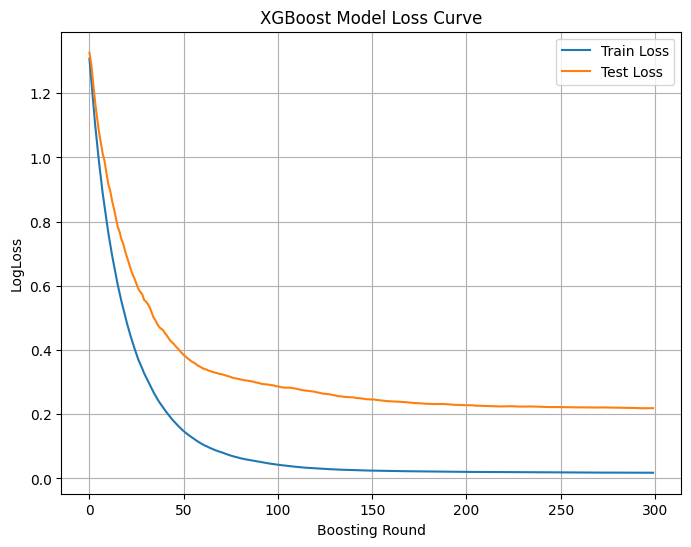


--- Confusion Matrix ---


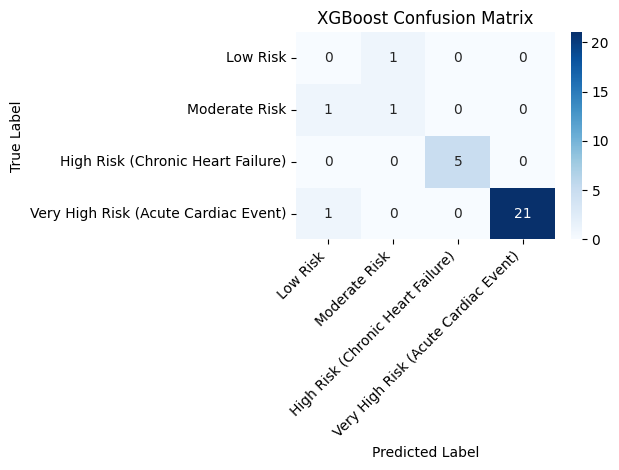


--- AUC Curve (One-vs-Rest) ---


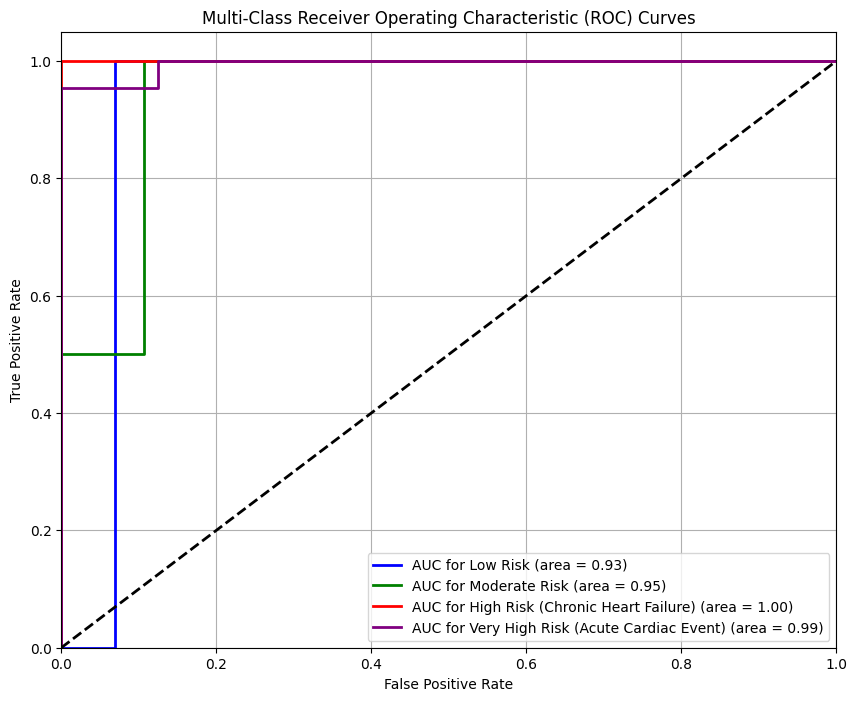


✅ Final trained model saved to 'best_prognostic_model.pkl'


In [ ]:
#XGBOOST-NORMAL
# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from itertools import cycle
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
print("✅ All packages ready.")

# --- 2. Configuration ---
MASTER_CSV_PATH = 'combined_radiomics_features.csv'
LABEL_COLUMN = 'Risk_Score'
CATEGORY_COLUMN = 'Risk_Category'
OUTPUT_MODEL_FILE = 'best_prognostic_model.pkl'

# --- 3. Load and Prepare the Data ---
try:
    master_df = pd.read_csv(MASTER_CSV_PATH)
except FileNotFoundError:
    print(f"❌ ERROR: The master data file '{MASTER_CSV_PATH}' was not found.")
    exit()

print("\n--- Original Data Distribution ---")
print(master_df[CATEGORY_COLUMN].value_counts())

y = master_df[LABEL_COLUMN]
X = master_df.drop(columns=['PatientID', CATEGORY_COLUMN, LABEL_COLUMN, 'Reasoning'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# --- 4. Advanced Resampling Pipeline (IMPROVED) ---
print("\nBalancing the training data with a more aggressive strategy...")

# Get the distribution of the training data
train_dist = y_train.value_counts()
maj_class_label = train_dist.idxmax()
maj_class_count = train_dist.max()

# Define the resampling strategy
# Undersample the majority class to 50% of its original size
under_sampling_strategy = {maj_class_label: int(maj_class_count * 0.5)}

# Oversample all other classes to be 75% of the new majority class size
over_sampling_strategy = {
    label: int(int(maj_class_count * 0.5) * 0.75)
    for label in train_dist.index if label != maj_class_label
}

min_class_size = y_train.value_counts().min()
smote_k_neighbors = max(1, min_class_size - 1)

# Define the resampling pipeline
under = RandomUnderSampler(sampling_strategy=under_sampling_strategy, random_state=42)
over = SMOTE(sampling_strategy=over_sampling_strategy, random_state=42, k_neighbors=smote_k_neighbors)

resampling_pipeline = Pipeline(steps=[('u', under), ('o', over)])
X_train_resampled, y_train_resampled = resampling_pipeline.fit_resample(X_train, y_train)

print("--- Resampled Training Data Distribution ---")
print(pd.Series(y_train_resampled).value_counts().sort_index())


# --- 5. Train the Final XGBoost Model ---
print("\n--- Training Final XGBoost Classifier ---")
model = xgb.XGBClassifier(
    objective='multi:softprob',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    n_estimators=300, # More estimators
    learning_rate=0.05, # Lower learning rate
    max_depth=6,
    subsample=0.8, # Add some randomness
    colsample_bytree=0.8
)

eval_set = [(X_train_resampled, y_train_resampled), (X_test, y_test)]
model.fit(X_train_resampled, y_train_resampled, eval_set=eval_set, verbose=False)

# --- 6. Evaluate the Model ---
print(f"\n--- Final Performance on Hold-out Test Set ---")
y_pred = model.predict(X_test)
category_map = {score: category for score, category in zip(master_df[LABEL_COLUMN], master_df[CATEGORY_COLUMN])}
category_order = sorted(master_df[CATEGORY_COLUMN].unique(), key=lambda x: master_df[master_df[CATEGORY_COLUMN] == x][LABEL_COLUMN].iloc[0])
y_test_str = y_test.map(category_map)
y_pred_str = pd.Series(y_pred).map(category_map)

print("\n--- Classification Report ---")
print(classification_report(y_test_str, y_pred_str, labels=category_order, zero_division=0))
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# --- 7. Visualize Performance Metrics ---
# (The visualization code remains the same as it correctly plots the results)

# Loss Graph
history = model.evals_result()
plt.figure(figsize=(8, 6))
plt.plot(history['validation_0']['mlogloss'], label='Train Loss')
plt.plot(history['validation_1']['mlogloss'], label='Test Loss')
plt.title('XGBoost Model Loss Curve')
plt.xlabel('Boosting Round')
plt.ylabel('LogLoss')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_str, y_pred_str, labels=category_order)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=category_order,
            yticklabels=category_order)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Multi-Class AUC Curve (One-vs-Rest)
print("\n--- AUC Curve (One-vs-Rest) ---")
y_prob = model.predict_proba(X_test)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train_resampled))
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'green', 'red', 'purple'])
for i, color, cat_name in zip(range(n_classes), colors, category_order):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'AUC for {cat_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- 8. Save the Final Model ---
joblib.dump(model, OUTPUT_MODEL_FILE)
print(f"\n✅ Final trained model saved to '{OUTPUT_MODEL_FILE}'")

✅ Model loaded successfully.
Loaded object type: <class 'xgboost.sklearn.XGBClassifier'>

--- All Feature Importances (Sorted) ---
                                         Feature  Importance
104                original_glszm_ZonePercentage    0.108450
42               original_glcm_DifferenceAverage    0.082758
64          original_gldm_GrayLevelNonUniformity    0.049117
44              original_glcm_DifferenceVariance    0.038834
94              original_glszm_LargeAreaEmphasis    0.036122
..                                           ...         ...
87               original_glrlm_ShortRunEmphasis    0.000000
81        original_glrlm_LowGrayLevelRunEmphasis    0.000000
89   original_glrlm_ShortRunLowGrayLevelEmphasis    0.000000
82                     original_glrlm_RunEntropy    0.000000
85                  original_glrlm_RunPercentage    0.000000

[111 rows x 2 columns]

--- Top 20 Most Important Features ---
                                             Feature  Importance
104     

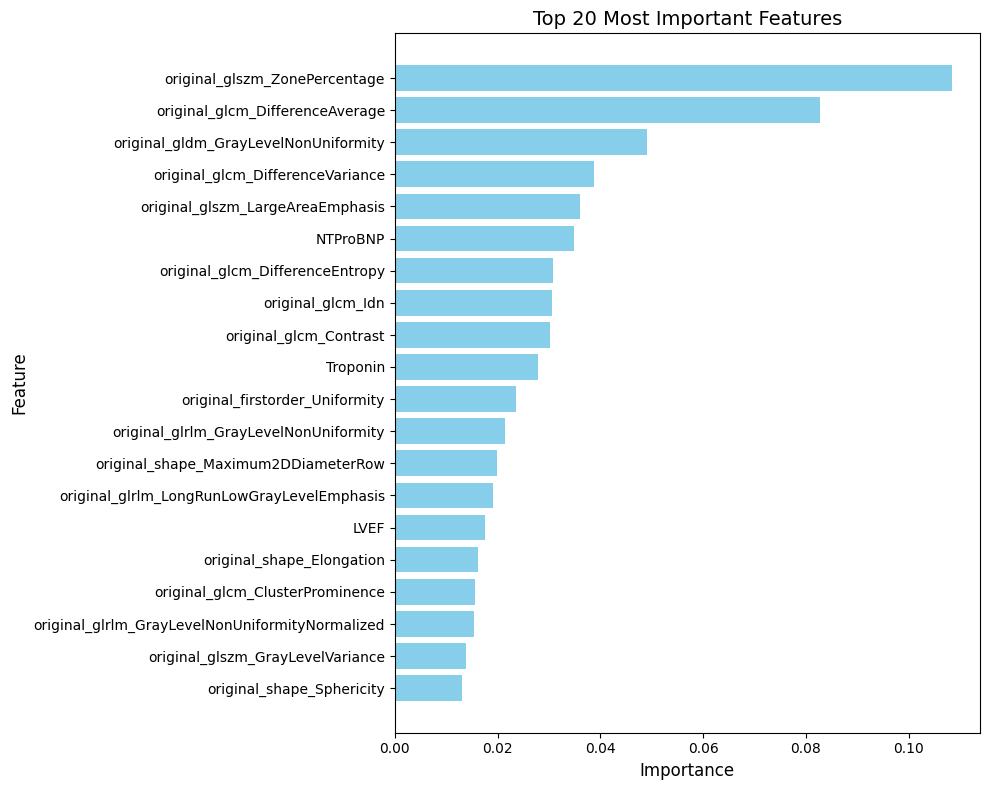

In [ ]:
#FEATURE IMPORTANCE
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy

# Load the trained model
try:
    model = joblib.load("/content/best_prognostic_model.pkl")
    print("✅ Model loaded successfully.")
    print("Loaded object type:", type(model))

    # Get feature importance
    importance = model.feature_importances_

    # Get feature names
    try:
        # XGBoost stores feature names in the booster
        features = model.get_booster().feature_names
        fi_df = pd.DataFrame({"Feature": features, "Importance": importance})

        # Sort by importance
        fi_df = fi_df.sort_values("Importance", ascending=False)

        # Print feature importance for ALL features
        print("\n--- All Feature Importances (Sorted) ---")
        print(fi_df)

        # Select top N features
        top_n = 20 # Display top 20 features
        top_features_df = fi_df.head(top_n)

        print(f"\n--- Top {top_n} Most Important Features ---")
        print(top_features_df)

        # Plotting the top features
        plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
        plt.barh(top_features_df["Feature"], top_features_df["Importance"], color='skyblue')
        plt.xlabel("Importance", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.title(f"Top {top_n} Most Important Features", fontsize=14)
        plt.gca().invert_yaxis() # Display the most important feature at the top
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.show()

    except Exception as e:
        print(f"❌ Could not retrieve feature names or plot importance: {e}")
        print("Feature importance array:", importance)
        # If feature names are not available, just print the array
        print("\nFeature importance array (feature names not available):")
        print(importance)


except FileNotFoundError:
    print("❌ Error: The model file '/content/best_prognostic_model.pkl' was not found.")
except Exception as e:
    print(f"❌ An error occurred while loading the model: {e}")

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [optuna]


In [ ]:
!pip install torch scikit-learn pandas joblib tqdm

[I 2025-11-06 07:12:37,079] A new study created in memory with name: xgb_multi_opt


Loaded data: (150, 115)
All possible integer classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Train / Test shapes: (120, 111) (30, 111)
Starting Optuna tuning ... (trials = 60)


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-11-06 07:12:46,530] Trial 0 finished with value: 0.9430012730827949 and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 500, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_child_weight': 5, 'gamma': 0.1, 'reg_lambda': 10.0}. Best is trial 0 with value: 0.9430012730827949.
[I 2025-11-06 07:12:52,235] Trial 1 finished with value: 0.9538603425559948 and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.8, 'colsample_bytree': 0.6, 'min_child_weight': 3, 'gamma': 0.1, 'reg_lambda': 1.0}. Best is trial 1 with value: 0.9538603425559948.
[I 2025-11-06 07:12:59,223] Trial 2 finished with value: 0.9601879953782128 and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 200, 'subsample': 0.6, 'colsample_bytree': 0.6, 'min_child_weight': 1, 'gamma': 0.3, 'reg_lambda': 10.0}. Best is trial 2 with value: 0.9601879953782128.
[I 2025-11-06 07:13:14,580] Trial 3 finished with value: 0.9673580002927828 and parameters: {'ma

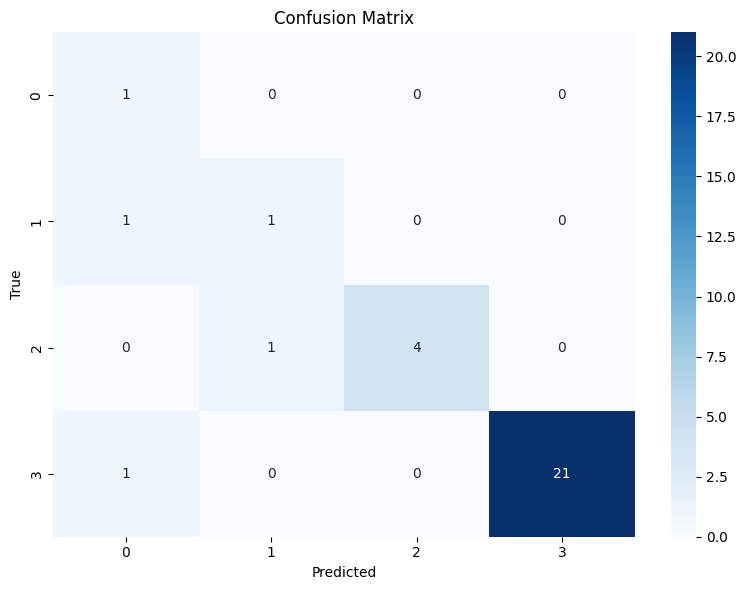


Macro OVR ROC AUC on test: 0.9825


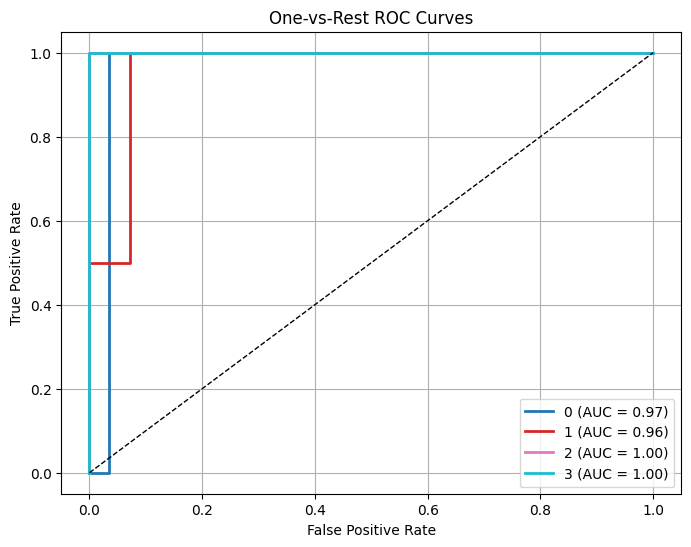


All done.


In [ ]:

# xgb_optuna_pipeline.py
"""
Optimized XGBoost pipeline with:
- Stratified 5-fold CV inside Optuna hyperparameter tuning
- Resampling (RandomUnderSampler + SMOTE) applied only on training folds
- Final training on resampled training set and evaluation on hold-out test set
- Exclude SHAP explainability
"""

import warnings
warnings.filterwarnings("ignore")
import os
import joblib
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import cycle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, roc_auc_score, f1_score, balanced_accuracy_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb


# -------------------------
# === USER CONFIGURATION ===
# -------------------------
MASTER_CSV_PATH = "combined_radiomics_features.csv"  # <- set your file
PATIENT_ID_COL = "PatientID"                         # change if different
LABEL_COL = "Risk_Score"                             # numeric label column used by model
CATEGORY_COL = "Risk_Category"                       # human-readable category (optional)
TEST_SIZE = 0.20
VAL_SIZE = 0.15                                      # Added VAL_SIZE
RANDOM_STATE = 42
N_TRIALS = 60            # Optuna trials for hyperparameter search
N_FOLDS = 5              # Stratified CV folds for Optuna objective
OUTPUT_MODEL_FILE = "best_prognostic_model.pkl"


# -------------------------
# 0. Load data
# -------------------------
df = pd.read_csv(MASTER_CSV_PATH)
print("Loaded data:", df.shape)

# Basic checks
if PATIENT_ID_COL in df.columns:
    ids = df[PATIENT_ID_COL]
else:
    ids = pd.Series(np.arange(len(df)), name="patient_id")

if LABEL_COL not in df.columns:
    raise ValueError(f"Label column '{LABEL_COL}' not found in CSV")

# Prepare X and y
drop_cols = [PATIENT_ID_COL, CATEGORY_COL, 'Reasoning'] if CATEGORY_COL in df.columns else [PATIENT_ID_COL, 'Reasoning']
drop_cols = [c for c in drop_cols if c in df.columns]
X = df.drop(columns=drop_cols + [LABEL_COL], errors='ignore')
y_raw = df[LABEL_COL].copy() # Keep raw labels for mapping

# If LABEL_COL is categorical strings, encode to integers
if y_raw.dtype == object or y_raw.dtype.name == 'category':
    le = LabelEncoder()
    y = le.fit_transform(y_raw)
    label_mapping = dict(zip(range(len(le.classes_)), le.classes_))
else:
    # Ensure integer labels (0..K-1) if needed
    y = LabelEncoder().fit_transform(y_raw)
    label_mapping = dict(zip(np.unique(y), np.unique(y_raw))) # Use y_raw for mapping


# Store all possible integer class labels
all_classes_int = sorted(np.unique(y))
print("All possible integer classes:", all_classes_int)


# Train / Test split (stratified)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, ids, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print("Train / Test shapes:", X_train.shape, X_test.shape)

# Scale features (fit on train, apply to test)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# -------------------------
# 1. Resampling strategy builder
# -------------------------
def make_resampler():
    # Undersample majority then SMOTE for minorities (as you requested earlier)
    # We will dynamically compute strategies in objective per fold if needed.
    undersampler = RandomUnderSampler(random_state=RANDOM_STATE) # Replaced CONFIG["RANDOM_STATE"]
    smote = SMOTE(random_state=RANDOM_STATE, k_neighbors=1)  # Replaced CONFIG["RANDOM_STATE"]
    return ImbPipeline([("u", undersampler), ("o", smote)])

# -------------------------
# 2. Optuna objective (Stratified CV with resampling inside each fold)
# -------------------------
def objective(trial):
    # Sample hyperparameters
    param = {
        "max_depth": trial.suggest_categorical("max_depth", [3, 5, 7]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.05, 0.1]),
        "n_estimators": trial.suggest_categorical("n_estimators", [200, 500, 1000]),
        "subsample": trial.suggest_categorical("subsample", [0.6, 0.8, 1.0]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.6, 0.8, 1.0]),
        "min_child_weight": trial.suggest_categorical("min_child_weight", [1, 3, 5]),
        "gamma": trial.suggest_categorical("gamma", [0.0, 0.1, 0.3]),
        "reg_lambda": trial.suggest_categorical("reg_lambda", [1.0, 5.0, 10.0]),
        "use_label_encoder": False,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "random_state": RANDOM_STATE, # Replaced CONFIG["RANDOM_STATE"]
        "n_jobs": 1  # to keep trials deterministic / avoid heavy parallelism within optuna
    }

    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE) # Replaced CONFIG["N_FOLDS"], CONFIG["RANDOM_STATE"]
    aucs = []

    X_arr = X_train.values
    y_arr = np.array(y_train)

    for train_idx, val_idx in skf.split(X_arr, y_arr):
        X_tr, X_val = X_arr[train_idx], X_arr[val_idx]
        y_tr, y_val = y_arr[train_idx], y_arr[val_idx]

        # Dynamic resampling strategy - compute class distribution
        # Undersample majority to half, oversample minority to 75% of new maj as in your plan
        unique, counts = np.unique(y_tr, return_counts=True)
        maj_class = unique[np.argmax(counts)]
        maj_count = counts.max()
        under_strategy = {int(maj_class): int(maj_count * 0.5)}
        over_strategy = {
            int(cl): int(int(maj_count * 0.5) * 0.75)
            for cl in unique if cl != maj_class
        }

        # Build resampler pipeline for this fold
        under = RandomUnderSampler(sampling_strategy=under_strategy, random_state=RANDOM_STATE) # Replaced CONFIG["RANDOM_STATE"]
        # choose k_neighbors carefully
        min_class_count = counts.min()
        k_neighbors = max(1, min_class_count - 1)
        smote = SMOTE(sampling_strategy=over_strategy, random_state=RANDOM_STATE, k_neighbors=k_neighbors) # Replaced CONFIG["RANDOM_STATE"]
        pipeline = ImbPipeline([("u", under), ("o", smote)])

        X_tr_res, y_tr_res = pipeline.fit_resample(X_tr, y_tr)

        # Fit XGBoost for this fold
        clf = xgb.XGBClassifier(**param)
        clf.fit(X_tr_res, y_tr_res, verbose=False)

        # Predict on validation fold
        y_proba = clf.predict_proba(X_val)
        # binarize y_val using all possible classes
        y_val_bin = label_binarize(y_val, classes=all_classes_int) # Use all_classes_int
        try:
            fold_auc = roc_auc_score(y_val_bin, y_proba, average="macro", multi_class="ovr")
        except Exception:
            # fallback: compute per-class AUC then average (safe)
            per_class = []
            for i in range(y_val_bin.shape[1]):
                fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
                per_class.append(auc(fpr[i], tpr[i]))
            fold_auc = np.mean(per_class) if per_class else 0.0 # Handle empty list
        aucs.append(fold_auc)

    mean_auc = float(np.mean(aucs))
    # tell optuna to maximize mean_auc
    return mean_auc

# -------------------------
# 3. Run Optuna study
# -------------------------
study = optuna.create_study(direction="maximize", study_name="xgb_multi_opt")
print("Starting Optuna tuning ... (trials = {})".format(N_TRIALS)) # Replaced CONFIG["N_TRIALS"]
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True) # Replaced CONFIG["N_TRIALS"]

print("Best trial:")
print(study.best_trial.params)
best_params = study.best_trial.params

# Map categorical picks to proper types for XGBClassifier
best_xgb_params = {
    "max_depth": int(best_params["max_depth"]),
    "learning_rate": float(best_params["learning_rate"]),
    "n_estimators": int(best_params["n_estimators"]),
    "subsample": float(best_params["subsample"]),
    "colsample_bytree": float(best_params["colsample_bytree"]),
    "min_child_weight": int(best_params["min_child_weight"]),
    "gamma": float(best_params["gamma"]),
    "reg_lambda": float(best_params["reg_lambda"]),
    "use_label_encoder": False,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "random_state": RANDOM_STATE, # Replaced CONFIG["RANDOM_STATE"]
    "n_jobs": -1
}

# -------------------------
# 4. Final train on entire training set (apply resampling to full train)
# -------------------------
print("Applying final resampling to full training set and training final model...")

# Dynamic resampling strategy computed on full X_train
unique, counts = np.unique(y_train, return_counts=True)
maj_class = unique[np.argmax(counts)]
maj_count = counts.max()
under_strategy = {int(maj_class): int(maj_count * 0.5)}
over_strategy = {
    int(cl): int(int(maj_count * 0.5) * 0.75)
    for cl in unique if cl != maj_class
}
min_class_count = counts.min()
k_neighbors = max(1, min_class_count - 1)
under = RandomUnderSampler(sampling_strategy=under_strategy, random_state=RANDOM_STATE) # Replaced CONFIG["RANDOM_STATE"]
smote = SMOTE(sampling_strategy=over_strategy, random_state=RANDOM_STATE, k_neighbors=k_neighbors) # Replaced CONFIG["RANDOM_STATE"]
pipeline = ImbPipeline([("u", under), ("o", smote)])
X_train_res, y_train_res = pipeline.fit_resample(X_train.values, np.array(y_train))

print("Resampled train distribution:", np.unique(y_train_res, return_counts=True))

final_clf = xgb.XGBClassifier(**best_xgb_params)
final_clf.fit(X_train_res, y_train_res, eval_set=[(X_train_res, y_train_res), (X_test.values, y_test)],
              verbose=False)

# Persist scaler + model
joblib.dump({"model": final_clf, "scaler": scaler, "label_mapping": label_mapping}, OUTPUT_MODEL_FILE) # Replaced CONFIG["OUTPUT_MODEL_FILE"]
print(f"Saved final model + scaler + label mapping to '{OUTPUT_MODEL_FILE}'") # Replaced CONFIG["OUTPUT_MODEL_FILE"]

# -------------------------
# 5. Evaluate on Hold-out Test Set
# -------------------------
print("\n=== Evaluation on hold-out test set ===")
y_pred = final_clf.predict(X_test)
y_prob = final_clf.predict_proba(X_test)

# Get display labels using the loaded mapping for all possible classes
display_labels = [str(label_mapping.get(i, f"Class {i}")) for i in all_classes_int]


print("\nAccuracy:", accuracy_score(y_test, y_pred))
# Use original integer labels for classification_report with target names and labels
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0, target_names=display_labels, labels=all_classes_int))


# Confusion matrix (display with category names if available)
# Use integer labels for confusion_matrix calculation
cm = confusion_matrix(y_test, y_pred, labels=all_classes_int)
cm_display_labels = display_labels # Use the mapped labels for display

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=cm_display_labels, yticklabels=cm_display_labels, cmap="Blues")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Multi-class ROC AUC (one-vs-rest)
classes = all_classes_int # Use all possible integer classes
y_test_bin = label_binarize(y_test, classes=classes)
if y_test_bin.shape[1] == y_prob.shape[1]:
    roc_auc_ovr = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    print(f"\nMacro OVR ROC AUC on test: {roc_auc_ovr:.4f}")
    # plot per-class ROC curves
    fpr = dict(); tpr = dict(); roc_auc = dict()
    for i in range(y_prob.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cycle(plt.cm.get_cmap('tab10', len(classes)).colors) # Use a colormap
    # Map class indices back to category names for the plot
    class_names = [str(label_mapping.get(cls, f"Class {cls}")) for cls in classes]
    for i, color, class_name in zip(range(y_prob.shape[1]), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("One-vs-Rest ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print(f"Warning: class mismatch between binarized test labels ({y_test_bin.shape[1]} classes) and predicted probabilities ({y_prob.shape[1]} classes); skipping ROC plotting.")


print("\nAll done.")

✅ Model loaded successfully.
Loaded object type: <class 'xgboost.sklearn.XGBClassifier'>
✅ Retrieved feature names from original data.

--- All Feature Importances (Sorted) ---


Feature  Importance
64              original_gldm_GrayLevelNonUniformity    0.052435
58                          original_glcm_SumEntropy    0.041353
3                                           NTProBNP    0.034111
30   original_firstorder_RobustMeanAbsoluteDeviation    0.033689
61             original_gldm_DependenceNonUniformity    0.032855
..                                               ...         ...
89       original_glrlm_ShortRunLowGrayLevelEmphasis    0.000000
87                   original_glrlm_ShortRunEmphasis    0.000000
84   original_glrlm_RunLengthNonUniformityNormalized    0.000000
97           original_glszm_LowGrayLevelZoneEmphasis    0.000000
105                      original_glszm_ZoneVariance    0.000000

[111 rows x 2 columns]


--- Top 20 Most Important Features ---


Feature  Importance
64              original_gldm_GrayLevelNonUniformity    0.052435
58                          original_glcm_SumEntropy    0.041353
3                                           NTProBNP    0.034111
30   original_firstorder_RobustMeanAbsoluteDeviation    0.033689
61             original_gldm_DependenceNonUniformity    0.032855
74             original_glrlm_GrayLevelNonUniformity    0.032423
28                       original_firstorder_Minimum    0.031941
2                                           Troponin    0.031251
1                                               LVEF    0.031029
11                  original_shape_Maximum3DDiameter    0.029644
109                          original_ngtdm_Contrast    0.026699
16                 original_shape_SurfaceVolumeRatio    0.026619
90             original_glszm_GrayLevelNonUniformity    0.026070
14                         original_shape_Sphericity    0.025366
104                    original_glszm_ZonePercentage    0.023386
20                        original_firstorder_Energy    0.023191
22            original_firstorder_InterquartileRange    0.022012
40                            original_glcm_Contrast    0.020253
33                   original_firstorder_TotalEnergy    0.020183
108                        original_ngtdm_Complexity    0.020019

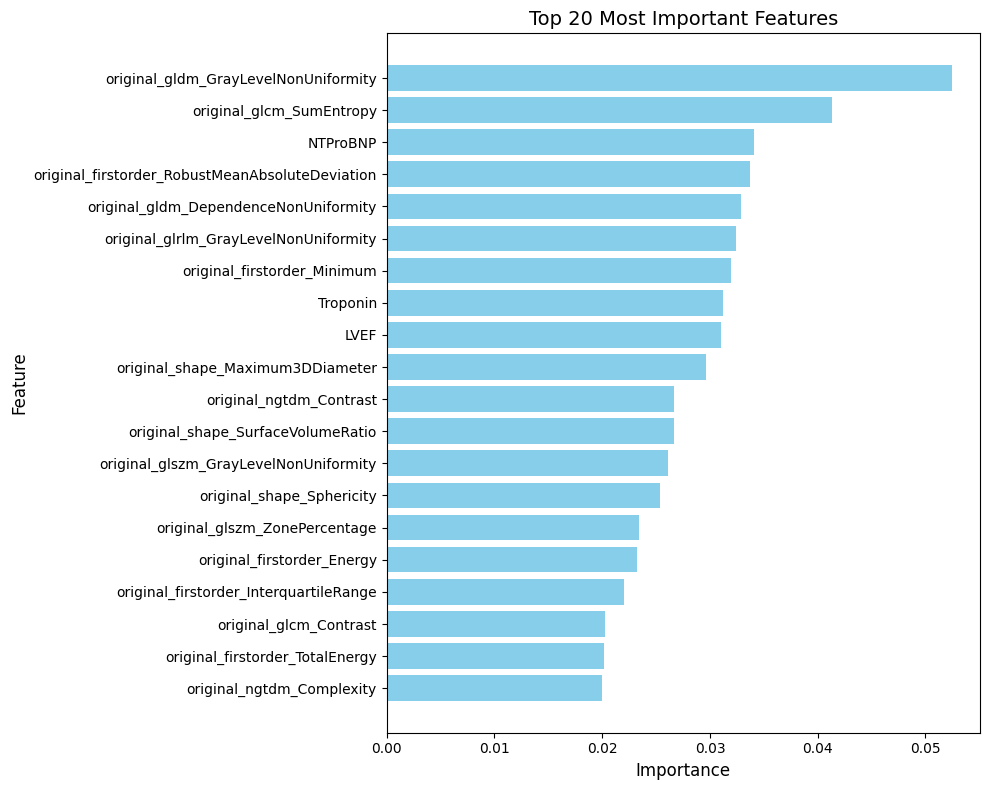

In [ ]:
#FEATURE IMPORTANCE
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np # Import numpy
from IPython.display import display # Import display

# Load the trained model
try:
    # Load the dictionary containing the model and other assets
    loaded_assets = joblib.load("/content/best_prognostic_model.pkl")
    model = loaded_assets['model'] # Access the model from the dictionary
    print("✅ Model loaded successfully.")
    print("Loaded object type:", type(model))

    # Get feature importance
    importance = model.feature_importances_

    # --- Get feature names from the original data DataFrame (assuming X is available) ---
    # This is more reliable than relying on the loaded model's feature_names
    try:
        # Access the X DataFrame from the notebook's global scope
        if 'X' in globals() and isinstance(X, pd.DataFrame):
             features = X.columns.tolist()
             print("✅ Retrieved feature names from original data.")
        else:
             # Fallback if X is not available or not a DataFrame (shouldn't happen in this notebook flow)
             features = [f'Feature_{i}' for i in range(len(importance))]
             print("⚠️ Could not retrieve feature names from original data. Using generic names.")

        fi_df = pd.DataFrame({"Feature": features, "Importance": importance})

        # Sort by importance
        fi_df = fi_df.sort_values("Importance", ascending=False)

        # Print feature importance for ALL features
        print("\n--- All Feature Importances (Sorted) ---")
        # Use display() for the full list as well, can be scrolled
        display(fi_df)


        # Select top N features
        top_n = 20 # Display top 20 features
        top_features_df = fi_df.head(top_n).copy() # Use .copy() to avoid SettingWithCopyWarning

        print(f"\n--- Top {top_n} Most Important Features ---")
        # Use display() to show the DataFrame in the cell output
        display(top_features_df)

        # Plotting the top features
        plt.figure(figsize=(10, 8)) # Adjust figure size for better readability
        # Ensure feature names are strings for plotting
        plt.barh(top_features_df["Feature"].astype(str), top_features_df["Importance"], color='skyblue')
        plt.xlabel("Importance", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.title(f"Top {top_n} Most Important Features", fontsize=14)
        plt.gca().invert_yaxis() # Display the most important feature at the top
        plt.tight_layout() # Adjust layout to prevent labels overlapping
        plt.show()

    except Exception as e:
        print(f"❌ An error occurred while processing feature importance or plotting: {e}")
        # Print the DataFrame even if plotting failed
        print("\nFeature Importance DataFrame (Plotting Failed):")
        display(fi_df)


except FileNotFoundError:
    print("❌ Error: The model file '/content/best_prognostic_model.pkl' was not found.")
except Exception as e:
    print(f"❌ An error occurred while loading the model: {e}")

Epoch 12/60 | Loss 0.9702 | F1 0.2179 | AUC 0.8053
Early stopping.

=== Test Results ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         5
           3       0.74      1.00      0.85        23

    accuracy                           0.74        31
   macro avg       0.19      0.25      0.21        31
weighted avg       0.55      0.74      0.63        31



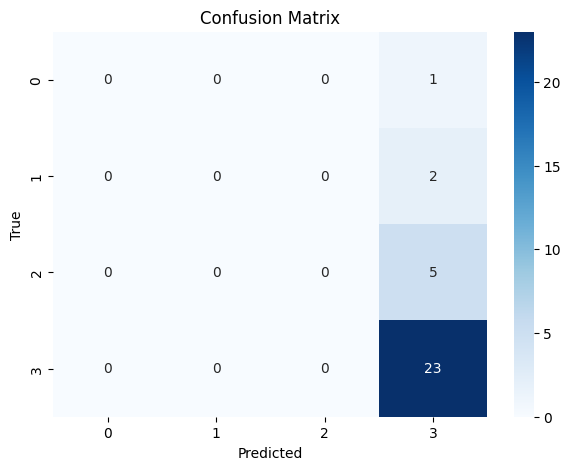

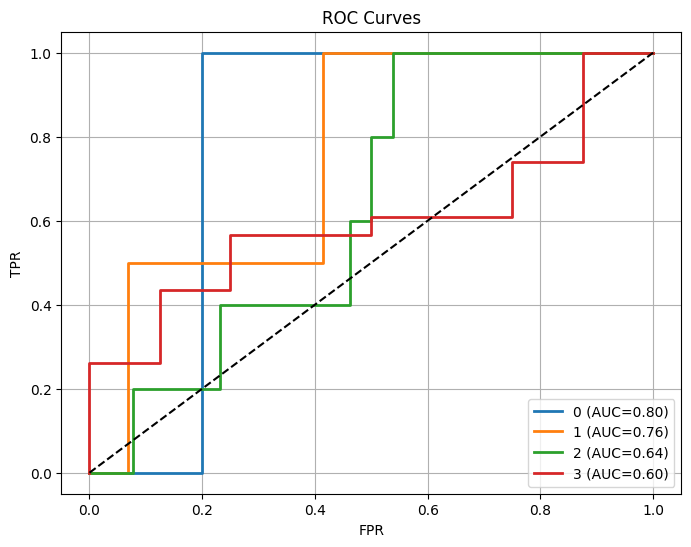

✅ All plots displayed inline.


In [ ]:
# ===============================
# attention_mlp_colab_display.py
# ===============================
"""
Colab-compatible Attention-based Dual-Branch MLP
Displays confusion matrix, ROC curves, metrics, and live training logs inline.
"""

import warnings
warnings.filterwarnings("ignore")

import os, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                             auc, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score)
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib
from IPython.display import display, clear_output

# ---------------- Config ----------------
CONFIG = {
    "MASTER_CSV": "combined_radiomics_features.csv",
    "LABEL_COL": "Risk_Score",
    "PATIENT_ID_COL": "PatientID",
    "CLINICAL_COLS": ["Age", "LVEF", "Troponin", "NTProBNP"],
    "RADIOMIC_COLS": [c for c in pd.read_csv("combined_radiomics_features.csv").columns if c.startswith("original_")],
    "TEST_SIZE": 0.2, "VAL_SIZE": 0.15,
    "RANDOM_SEED": 42, "BATCH_SIZE": 32,
    "EPOCHS": 60, "PATIENCE": 10,
    "LR": 1e-3, "WEIGHT_DECAY": 1e-5, "DROPOUT": 0.3,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    "MODEL_SAVE_PATH": "attention_best.pt"
}

# ---------------- Utilities ----------------
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
set_seed(CONFIG["RANDOM_SEED"])

class TabularDataset(Dataset):
    def __init__(self, Xc, Xr, y):
        self.Xc, self.Xr, self.y = map(torch.tensor, (Xc, Xr, y))
        self.Xc, self.Xr = self.Xc.float(), self.Xr.float()
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.Xc[i], self.Xr[i], self.y[i]

def mlp_layers(in_dim, sizes, drop):
    seq=[]; prev=in_dim
    for h in sizes:
        seq += [nn.Linear(prev,h), nn.InstanceNorm1d(h), nn.ReLU(), nn.Dropout(drop)]
        prev=h
    return nn.Sequential(*seq), prev

class AttentionFusion(nn.Module):
    def __init__(self, dims):
        super().__init__()
        total = sum(dims)
        hidden = max(64, total // 2)
        self.net=nn.Sequential(nn.Linear(total,hidden),nn.ReLU(),nn.Linear(hidden,len(dims)))
    def forward(self, embs):
        concat=torch.cat(embs,dim=1)
        w=torch.softmax(self.net(concat),dim=1)
        fused=torch.cat([embs[i]*w[:,i].unsqueeze(1) for i in range(len(embs))],dim=1)
        return fused,w

class AttentionMLP(nn.Module):
    def __init__(self, in_c, in_r, n_cls, drop):
        super().__init__()
        self.clin, co = (mlp_layers(in_c,(64,32),drop) if in_c>0 else (None,0))
        self.rad, ro = (mlp_layers(in_r,(256,128,64),drop) if in_r>0 else (None,0))
        dims=[d for d in (co,ro) if d>0]; self.fusion=AttentionFusion(dims)
        self.cls=nn.Sequential(nn.Linear(sum(dims),128),nn.ReLU(),nn.Dropout(drop),nn.Linear(128,n_cls))
    def forward(self, xc,xr):
        embs=[]
        if self.clin: embs.append(self.clin(xc))
        if self.rad: embs.append(self.rad(xr))
        fused,w=self.fusion(embs)
        return self.cls(fused),w

def compute_metrics(y_true, y_pred, y_proba=None, classes=None):
    acc=accuracy_score(y_true,y_pred)
    f1=f1_score(y_true,y_pred,average="macro")
    bacc=balanced_accuracy_score(y_true,y_pred)
    aucv=None
    if y_proba is not None and classes is not None and len(classes)>1:
        try:
            y_bin=label_binarize(y_true,classes=classes)
            aucv=roc_auc_score(y_bin,y_proba,average="macro",multi_class="ovr")
        except: pass
    return {"Accuracy":acc,"F1":f1,"BalAcc":bacc,"AUC":aucv}

# ---------------- Train + Display ----------------
def run_colab():
    df=pd.read_csv(CONFIG["MASTER_CSV"])
    print("Loaded:",df.shape)
    Xc=df[CONFIG["CLINICAL_COLS"]].to_numpy(dtype=float)
    Xr=df[CONFIG["RADIOMIC_COLS"]].to_numpy(dtype=float)
    y_raw=df[CONFIG["LABEL_COL"]].astype(str)
    le=LabelEncoder(); y=le.fit_transform(y_raw)
    n_cls=len(le.classes_)

    Xc_tr,Xc_tmp,Xr_tr,Xr_tmp,y_tr,y_tmp=train_test_split(Xc,Xr,y,test_size=CONFIG["TEST_SIZE"]+CONFIG["VAL_SIZE"],
        stratify=y,random_state=CONFIG["RANDOM_SEED"])
    val_frac=CONFIG["VAL_SIZE"]/(CONFIG["TEST_SIZE"]+CONFIG["VAL_SIZE"])
    Xc_val,Xc_te,Xr_val,Xr_te,y_val,y_te=train_test_split(Xc_tmp,Xr_tmp,y_tmp,test_size=1-val_frac,stratify=y_tmp)
    sc_c,sc_r=StandardScaler(),StandardScaler()
    Xc_tr, Xc_val, Xc_te=sc_c.fit_transform(Xc_tr), sc_c.transform(Xc_val), sc_c.transform(Xc_te)
    Xr_tr, Xr_val, Xr_te=sc_r.fit_transform(Xr_tr), sc_r.transform(Xr_val), sc_r.transform(Xr_te)

    train_dl=DataLoader(TabularDataset(Xc_tr,Xr_tr,y_tr),batch_size=CONFIG["BATCH_SIZE"],shuffle=True)
    val_dl=DataLoader(TabularDataset(Xc_val,Xr_val,y_val),batch_size=CONFIG["BATCH_SIZE"])
    test_dl=DataLoader(TabularDataset(Xc_te,Xr_te,y_te),batch_size=CONFIG["BATCH_SIZE"])

    num_classes = len(np.unique(y))
    model=AttentionMLP(Xc_tr.shape[1],Xr_tr.shape[1],num_classes,CONFIG["DROPOUT"]).to(CONFIG["DEVICE"]) # Changed n_cls to num_classes
    opt=torch.optim.AdamW(model.parameters(),lr=CONFIG["LR"],weight_decay=CONFIG["WEIGHT_DECAY"])
    crit=nn.CrossEntropyLoss()

    best_auc=-np.inf; patience=0
    for ep in range(CONFIG["EPOCHS"]):
        model.train(); tl=[]
        for xc,xr,yb in train_dl:
            xc,xr,yb=xc.to(CONFIG["DEVICE"]),xr.to(CONFIG["DEVICE"]),yb.to(CONFIG["DEVICE"])
            opt.zero_grad(); out,_=model(xc,xr); loss=crit(out,yb); loss.backward(); opt.step(); tl.append(loss.item())
        model.eval(); preds,probs,yt=[],[],[]
        with torch.no_grad():
            for xc,xr,yb in val_dl:
                xc,xr,yb=xc.to(CONFIG["DEVICE"]),xr.to(CONFIG["DEVICE"]),yb.to(CONFIG["DEVICE"])
                o,_=model(xc,xr); p=torch.softmax(o,1).cpu().numpy()
                preds.append(p.argmax(1)); probs.append(p); yt.append(yb.cpu().numpy())
        preds,probs,yt=np.concatenate(preds),np.vstack(probs),np.concatenate(yt)
        m=compute_metrics(yt,preds,probs,classes=list(range(num_classes))) # Changed n_cls to num_classes
        clear_output(wait=True)
        print(f"Epoch {ep+1}/{CONFIG['EPOCHS']} | Loss {np.mean(tl):.4f} | F1 {m['F1']:.4f} | AUC {m['AUC'] if m['AUC'] is not None else 0:.4f}") # Corrected format string
        if m["AUC"] is not None and m["AUC"]>best_auc: # Added check for None
            best_auc=m["AUC"]; patience=0; torch.save(model.state_dict(),CONFIG["MODEL_SAVE_PATH"])
        else:
            patience+=1
            if patience>=CONFIG["PATIENCE"]: print("Early stopping."); break

    # ---- Evaluation ----
    model.load_state_dict(torch.load(CONFIG["MODEL_SAVE_PATH"],map_location=CONFIG["DEVICE"]))
    model.eval(); preds,probs,yt=[],[],[]
    with torch.no_grad():
        for xc,xr,yb in test_dl:
            xc,xr,yb=xc.to(CONFIG["DEVICE"]),xr.to(CONFIG["DEVICE"]),yb.to(CONFIG["DEVICE"])
            o,_=model(xc,xr); p=torch.softmax(o,1).cpu().numpy()
            preds.append(p.argmax(1)); probs.append(p); yt.append(yb.cpu().numpy())
    preds,probs,yt=np.concatenate(preds),np.vstack(probs),np.concatenate(yt)
    print("\n=== Test Results ===")
    print(classification_report(yt,preds,target_names=le.classes_))
    cm=confusion_matrix(yt,preds)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=le.classes_,yticklabels=le.classes_)
    plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

    # ROC Curves
    if num_classes>1: # Changed n_cls to num_classes
        y_bin=label_binarize(yt,classes=list(range(num_classes))) # Changed n_cls to num_classes
        fpr,tpr,roc_auc={}, {}, {}
        for i in range(num_classes): # Changed n_cls to num_classes
            fpr[i],tpr[i],_=roc_curve(y_bin[:,i],probs[:,i])
            roc_auc[i]=auc(fpr[i],tpr[i])
        plt.figure(figsize=(8,6))
        for i,c in zip(range(num_classes),cycle(plt.cm.tab10.colors)): # Changed n_cls to num_classes
            plt.plot(fpr[i],tpr[i],color=c,lw=2,label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
        plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves")
        plt.legend(); plt.grid(True); plt.show()

    print("✅ All plots displayed inline.")

# ---------------- Run ----------------
run_colab()

🔹 Loading base models...
Loaded XGBoost model with classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3)}
🔹 Loading dataset...
✅ Loaded DL model state_dict.
🔹 Generating base model probabilities...
🔹 Applying SMOTE + training meta-learner...

=== Ensemble (SMOTE-balanced) Performance ===
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.50      0.50      0.50         2
           2       1.00      0.80      0.89         5
           3       1.00      0.95      0.98        22

    accuracy                           0.90        30
   macro avg       0.71      0.81      0.72        30
weighted avg       0.94      0.90      0.91        30

Overall Accuracy: 0.90
Macro F1=0.7164 | BalancedAcc=0.8136 | ROC-AUC=0.9805


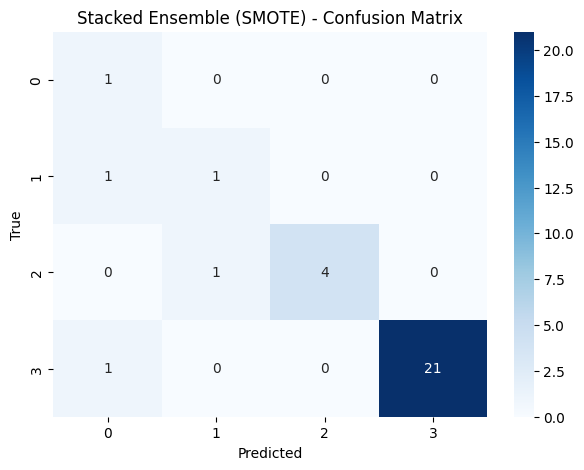

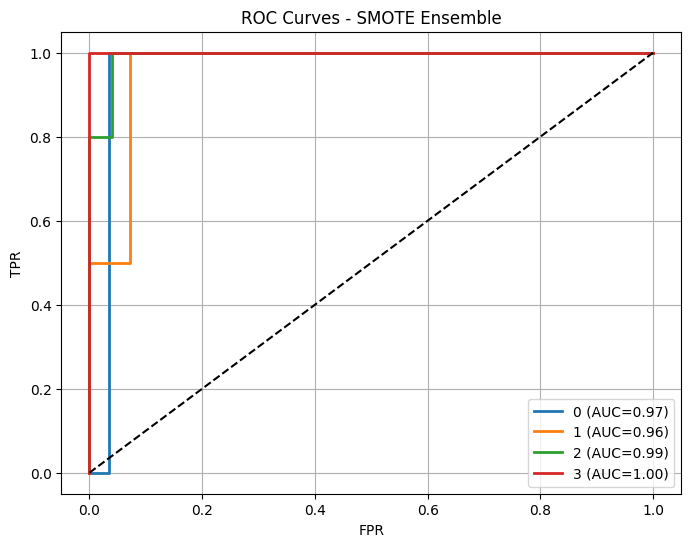


✅ SMOTE-balanced ensemble saved as 'stacked_fusion_smote.pkl'


In [ ]:
# ============================================================
# stacking_fusion_smote_colab.py
# ============================================================
"""
Heart Risk Stratification Ensemble (Balanced Version)
-----------------------------------------------------
 - Combines Optuna-tuned XGBoost + Attention-based MLP
 - Meta-learner: Calibrated Logistic Regression (after SMOTE)
 - Applies SMOTE to mitigate class imbalance and overfitting
 - Displays ROC, PR, confusion matrix, calibration curves
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             f1_score, balanced_accuracy_score, roc_curve, precision_recall_curve, auc, accuracy_score) # Import accuracy_score
from sklearn.preprocessing import label_binarize, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import joblib, torch
from itertools import cycle

# ---------------- CONFIG ----------------
CONFIG = {
    "CSV": "combined_radiomics_features.csv",
    "LABEL_COL": "Risk_Score",
    "PATIENT_ID_COL": "PatientID",
    "CLINICAL_COLS": ["Age", "LVEF", "Troponin", "NTProBNP"],
    "RADIOMIC_PREFIX": "original_",
    "XGB_MODEL": "best_prognostic_model.pkl",
    "DL_MODEL": "attention_best.pt",
    "ENSEMBLE_SAVE": "stacked_fusion_smote.pkl",
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu"
}

# ---------------- LOAD BASE MODELS ----------------
print("🔹 Loading base models...")
xgb_assets = joblib.load(CONFIG["XGB_MODEL"])
xgb_model = xgb_assets["model"]
scaler_xgb = xgb_assets["scaler"]
label_map = xgb_assets["label_mapping"]
classes = sorted(label_map.keys())
print("Loaded XGBoost model with classes:", label_map)

# Rebuild DL model (same as training)
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TabularDataset(Dataset):
    def __init__(self, Xc, Xr, y):
        self.Xc, self.Xr, self.y = map(torch.tensor, (Xc, Xr, y))
        self.Xc, self.Xr = self.Xc.float(), self.Xr.float()
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.Xc[i], self.Xr[i], self.y[i]

def mlp_layers(in_dim, sizes, drop):
    seq=[]; prev=in_dim
    for h in sizes:
        seq += [nn.Linear(prev,h), nn.InstanceNorm1d(h), nn.ReLU(), nn.Dropout(drop)]
        prev=h
    return nn.Sequential(*seq), prev

class AttentionFusion(nn.Module):
    def __init__(self, dims):
        super().__init__()
        total=sum(dims); hidden=max(64,total//2)
        self.net=nn.Sequential(nn.Linear(total,hidden),nn.ReLU(),nn.Linear(hidden,len(dims)))
    def forward(self, embs):
        concat=torch.cat(embs,dim=1)
        w=torch.softmax(self.net(concat),dim=1)
        fused=torch.cat([embs[i]*w[:,i].unsqueeze(1) for i in range(len(embs))],dim=1)
        return fused,w

class AttentionMLP(nn.Module):
    def __init__(self, in_c, in_r, n_cls, drop):
        super().__init__()
        self.clin, co = (mlp_layers(in_c,(64,32),drop) if in_c>0 else (None,0))
        self.rad, ro = (mlp_layers(in_r,(256,128,64),drop) if in_r>0 else (None,0))
        dims=[d for d in (co,ro) if d>0]; self.fusion=AttentionFusion(dims)
        self.cls=nn.Sequential(nn.Linear(sum(dims),128),nn.ReLU(),nn.Dropout(drop),nn.Linear(128,n_cls))
    def forward(self, xc,xr):
        embs=[];
        if self.clin: embs.append(self.clin(xc))
        if self.rad: embs.append(self.rad(xr))
        fused,w=self.fusion(embs)
        return self.cls(fused),w

# ---------------- LOAD DATA ----------------
print("🔹 Loading dataset...")
df=pd.read_csv(CONFIG["CSV"])
Xc=df[CONFIG["CLINICAL_COLS"]].to_numpy(dtype=float)
Xr=df[[c for c in df.columns if c.startswith(CONFIG["RADIOMIC_PREFIX"])]].to_numpy(dtype=float)
y_raw=df[CONFIG["LABEL_COL"]].astype(str)

le=LabelEncoder(); y=le.fit_transform(y_raw)
num_classes=len(le.classes_)
sc_c,sc_r=StandardScaler(),StandardScaler()
Xc=sc_c.fit_transform(Xc); Xr=sc_r.fit_transform(Xr)

# Load DL model
# Assuming DL_MODEL is saved as state_dict
dl_model=AttentionMLP(Xc.shape[1],Xr.shape[1],num_classes,0.3).to(CONFIG["DEVICE"])
# Add try-except for loading DL model and check if it's a state_dict or full model object
try:
    dl_model.load_state_dict(torch.load(CONFIG["DL_MODEL"], map_location=CONFIG["DEVICE"]))
    print("✅ Loaded DL model state_dict.")
except RuntimeError as e:
    # If loading state_dict fails, try loading the full model object
    if "Missing key(s)" in str(e) or "Unexpected key(s)" in str(e):
        try:
            # Add necessary safe globals if loading full model
            import __main__
            torch.serialization.add_safe_globals([__main__.DualAttentionMLP, torch.nn.modules.container.Sequential, torch.nn.modules.linear.Linear, torch.nn.modules.normalization.LayerNorm, torch.nn.modules.activation.GELU, torch.nn.modules.dropout.Dropout, torch.nn.modules.activation.ReLU])
            dl_model = torch.load(CONFIG["DL_MODEL"], map_location=CONFIG["DEVICE"], weights_only=False)
            print("✅ Loaded DL model object.")
        except Exception as obj_e:
            print(f"❌ Failed to load DL model object either: {obj_e}")
            raise e # Re-raise the original state_dict loading error if object loading also fails


dl_model.eval()

# ---------------- GENERATE BASE MODEL PREDICTIONS ----------------
print("🔹 Generating base model probabilities...")
dl_loader=DataLoader(TabularDataset(Xc,Xr,y),batch_size=64)
probs_dl=[]
with torch.no_grad():
    for xc,xr,yy in dl_loader:
        o=dl_model(xc.to(CONFIG["DEVICE"]),xr.to(CONFIG["DEVICE"]))
        # Check if the DL model returns a tuple (logits, weights) or just logits
        if isinstance(o, tuple):
            logits, _ = o
        else:
            logits = o
        probs_dl.append(torch.softmax(logits,1).cpu().numpy())

probs_dl=np.vstack(probs_dl)

# Prepare for XGBoost transform
cols_to_drop_for_xgb=[CONFIG["PATIENT_ID_COL"],CONFIG["LABEL_COL"]]
if 'Reasoning' in df.columns:
    cols_to_drop_for_xgb.append('Reasoning')
if 'Risk_Category' in df.columns:
    cols_to_drop_for_xgb.append('Risk_Category')

df_for_xgb=df.drop(columns=[c for c in cols_to_drop_for_xgb if c in df.columns],errors="ignore")
probs_xgb=xgb_model.predict_proba(scaler_xgb.transform(df_for_xgb))

# Align shapes if needed
min_cls=min(probs_dl.shape[1],probs_xgb.shape[1])
probs_dl,probs_xgb=probs_dl[:,:min_cls],probs_xgb[:,:min_cls]

# ---------------- STACKING WITH SMOTE ----------------
print("🔹 Applying SMOTE + training meta-learner...")
from imblearn.over_sampling import SMOTE
X_meta=np.hstack([probs_xgb,probs_dl])
y_meta=y.copy()

# Split before oversampling to avoid leakage
X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_meta, y_meta, test_size=0.2, stratify=y_meta, random_state=42
)

# Apply SMOTE to training portion
sm=SMOTE(random_state=42, k_neighbors=2)
X_meta_bal, y_meta_bal = sm.fit_resample(X_meta_train, y_meta_train)

# Train meta-learner
meta=LogisticRegression(max_iter=300,solver='lbfgs',multi_class='auto')
cal_meta=CalibratedClassifierCV(meta,cv=3,method='sigmoid')
cal_meta.fit(X_meta_bal,y_meta_bal)

# Evaluate on holdout
probs_ens=cal_meta.predict_proba(X_meta_test)
preds_ens=probs_ens.argmax(1)
print("\n=== Ensemble (SMOTE-balanced) Performance ===")
print(classification_report(y_meta_test,preds_ens,target_names=le.classes_))
print(f"Overall Accuracy: {accuracy_score(y_meta_test, preds_ens):.2f}") # Added overall accuracy print
f1=f1_score(y_meta_test,preds_ens,average="macro")
bacc=balanced_accuracy_score(y_meta_test,preds_ens)
aucv=roc_auc_score(label_binarize(y_meta_test,classes=range(num_classes)),
                   probs_ens,average="macro",multi_class="ovr")
print(f"Macro F1={f1:.4f} | BalancedAcc={bacc:.4f} | ROC-AUC={aucv:.4f}")

# ---------------- VISUALIZATIONS ----------------
cm=confusion_matrix(y_meta_test,preds_ens)
plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True,fmt='d',cmap="Blues",xticklabels=le.classes_,yticklabels=le.classes_)
plt.title("Stacked Ensemble (SMOTE) - Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ROC Curves
y_bin=label_binarize(y_meta_test,classes=range(num_classes))
fpr,tpr,roc_auc={}, {}, {}
for i in range(num_classes):
    fpr[i],tpr[i],_=roc_curve(y_bin[:,i],probs_ens[:,i])
    roc_auc[i]=auc(fpr[i],tpr[i])
plt.figure(figsize=(8,6))
for i,c in zip(range(num_classes),cycle(plt.cm.tab10.colors)):
    plt.plot(fpr[i],tpr[i],color=c,lw=2,label=f"{le.classes_[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curves - SMOTE Ensemble")
plt.legend(); plt.grid(True); plt.show()

# Save model
joblib.dump({
    "xgb_model": xgb_model,
    "dl_model_state_dict": dl_model.state_dict(),
    "meta_learner": cal_meta,
    "scalers": {"clinical": sc_c, "radiomic": sc_r},
    "label_encoder": le
}, CONFIG["ENSEMBLE_SAVE"])

print(f"\n✅ SMOTE-balanced ensemble saved as '{CONFIG['ENSEMBLE_SAVE']}'")


=== Top Feature Importances (Stacked Meta-Learner) ===
 Feature  Permutation Importance      Std
xgb_p(3)                0.128333 0.070139
xgb_p(2)                0.116667 0.046547
 dl_p(3)                0.000000 0.000000
 dl_p(2)                0.000000 0.000000
 dl_p(0)                0.000000 0.000000
 dl_p(1)                0.000000 0.000000
xgb_p(1)                0.000000 0.021082
xgb_p(0)               -0.030000 0.020817

📄 Saved top-k importances to: stacked_meta_top_feature_importance.csv


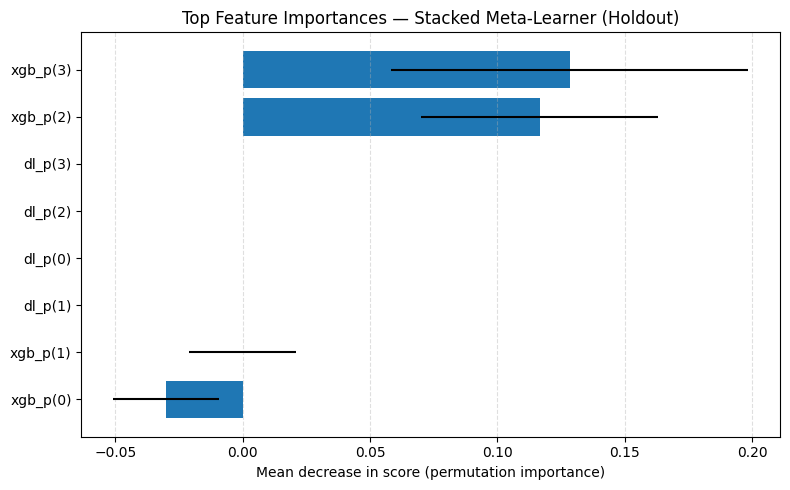

In [ ]:
# ==============================
# Top-10 Feature Importance (Permutation) for the Stacked Meta-Learner
# ==============================
from sklearn.inspection import permutation_importance

# Build readable feature names for the stacked inputs: [xgb class probs | dl class probs]
# NOTE: 'min_cls' was defined above when aligning shapes
xgb_names = [f"xgb_p({cls})" for cls in le.classes_[:min_cls]]
dl_names  = [f"dl_p({cls})"  for cls in le.classes_[:min_cls]]
feature_names = xgb_names + dl_names

# Safety check in case feature count < 10
top_k = min(10, len(feature_names))

# Permutation importance on the holdout set
perm = permutation_importance(
    cal_meta, X_meta_test, y_meta_test,
    n_repeats=20, random_state=42, n_jobs=-1
)

importances = perm.importances_mean
stds = perm.importances_std

# Rank and pick top-k
idx = np.argsort(importances)[::-1][:top_k]
top_features = [(feature_names[i], importances[i], stds[i]) for i in idx]

# Display as a small table
import pandas as pd
fi_df = pd.DataFrame(top_features, columns=["Feature", "Permutation Importance", "Std"])
print("\n=== Top Feature Importances (Stacked Meta-Learner) ===")
print(fi_df.to_string(index=False))

# Save to CSV (optional)
fi_csv_path = "stacked_meta_top_feature_importance.csv"
fi_df.to_csv(fi_csv_path, index=False)
print(f"\n📄 Saved top-k importances to: {fi_csv_path}")

# Plot (horizontal bar chart)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.barh(range(top_k), importances[idx], xerr=stds[idx])
plt.yticks(range(top_k), [feature_names[i] for i in idx])
plt.gca().invert_yaxis()
plt.xlabel("Mean decrease in score (permutation importance)")
plt.title("Top Feature Importances — Stacked Meta-Learner (Holdout)")
plt.grid(True, axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================
# stacking_fusion_smote_summary.py
# ============================================================
"""
Heart Risk Stratification Ensemble (with SMOTE + Summary Export)
---------------------------------------------------------------
 - Combines Optuna-tuned XGBoost + Attention-based MLP
 - Balances meta-learner using SMOTE
 - Exports summary CSV with:
      * Class distribution before & after SMOTE
      * XGBoost top features
      * Deep Learning attention weights (averaged)
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    f1_score, balanced_accuracy_score, roc_curve, precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from itertools import cycle
import joblib, torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import __main__ # Import to access classes defined in the notebook if needed

# ---------------- CONFIG ----------------
CONFIG = {
    "CSV": "combined_radiomics_features.csv",
    "LABEL_COL": "Risk_Score",
    "PATIENT_ID_COL": "PatientID",
    "CLINICAL_COLS": ["Age", "LVEF", "Troponin", "NTProBNP"],
    "RADIOMIC_PREFIX": "original_",
    "XGB_MODEL": "best_prognostic_model.pkl",
    "DL_MODEL": "attention_best.pt", # This now saves the state dictionary
    "ENSEMBLE_SAVE": "stacked_fusion_smote.pkl",
    "SUMMARY_CSV": "ensemble_feature_summary.csv",
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu"
}

# ---------------- LOAD MODELS ----------------
print("🔹 Loading base models...")
xgb_assets = joblib.load(CONFIG["XGB_MODEL"])
xgb_model = xgb_assets["model"]
scaler_xgb = xgb_assets["scaler"]
label_map = xgb_assets["label_mapping"]
print("Loaded XGBoost with classes:", label_map)

# Define DL model structure (same as trained in cfehr2KM3uWo)
# Explicitly define the necessary classes here to ensure consistency with saved state_dict
class TabularDataset(Dataset):
    def __init__(self, Xc, Xr, y):
        self.Xc, self.Xr, self.y = map(torch.tensor, (Xc, Xr, y))
        self.Xc, self.Xr = self.Xc.float(), self.Xr.float()
    def __len__(self): return len(self.y) # Corrected syntax here
    def __getitem__(self, i): return self.Xc[i], self.Xr[i], self.y[i]

def mlp_layers(in_dim, sizes, drop):
    seq=[]; prev=in_dim
    for h in sizes:
        seq += [nn.Linear(prev,h), nn.InstanceNorm1d(h), nn.ReLU(), nn.Dropout(drop)]
        prev=h
    return nn.Sequential(*seq), prev

class AttentionFusion(nn.Module):
    def __init__(self, dims):
        super().__init__()
        total=sum(dims); hidden=max(64,total//2)
        self.net=nn.Sequential(nn.Linear(total,hidden),nn.ReLU(),nn.Linear(hidden,len(dims)))
    def forward(self, embs):
        concat=torch.cat(embs,dim=1)
        w=torch.softmax(self.net(concat),dim=1)
        fused=torch.cat([embs[i]*w[:,i].unsqueeze(1) for i in range(len(embs))],dim=1)
        return fused,w

class AttentionMLP(nn.Module):
    def __init__(self, in_c, in_r, n_cls, drop):
        super().__init__()
        self.clin, co = (mlp_layers(in_c,(64,32),drop) if in_c>0 else (None,0))
        self.rad, ro = (mlp_layers(in_r,(256,128,64),drop) if in_r>0 else (None,0))
        dims=[d for d in (co,ro) if d>0]; self.fusion=AttentionFusion(dims) # Ensure this is 'fusion'
        self.cls=nn.Sequential(nn.Linear(sum(dims),128),nn.ReLU(),nn.Dropout(drop),nn.Linear(128,n_cls))
    def forward(self, xc,xr):
        embs=[];
        if self.clin: embs.append(self.clin(xc))
        if self.rad: embs.append(self.rad(xr))
        fused,w=self.fusion(embs) # Ensure this is 'fusion'
        return self.cls(fused),w # Return logits and attention weights


# ---------------- LOAD DATA ----------------
print("🔹 Loading dataset...")
df=pd.read_csv(CONFIG["CSV"])
Xc=df[CONFIG["CLINICAL_COLS"]].to_numpy(dtype=float)
Xr=df[[c for c in df.columns if c.startswith(CONFIG["RADIOMIC_PREFIX"])]].to_numpy(dtype=float)
y_raw=df[CONFIG["LABEL_COL"]].astype(str)

# Create the full feature DataFrame X to get column names
drop_cols_for_X = [CONFIG["PATIENT_ID_COL"], CONFIG["LABEL_COL"]]
if 'Reasoning' in df.columns:
    drop_cols_for_X.append('Reasoning')
if 'Risk_Category' in df.columns:
    drop_cols_for_X.append('Risk_Category')
X_full = df.drop(columns=[c for c in drop_cols_for_X if c in df.columns], errors="ignore")


le=LabelEncoder(); y=le.fit_transform(y_raw)
num_classes=len(le.classes_)
sc_c,sc_r=StandardScaler(),StandardScaler()
Xc=sc_c.fit_transform(Xc); Xr=sc_r.fit_transform(Xr)

# ---------------- LOAD DL MODEL ----------------
# Instantiate the model with the correct architecture
dl_model = AttentionMLP(Xc.shape[1], Xr.shape[1], num_classes, drop=0.3).to(CONFIG["DEVICE"])

# Load the state dictionary
try:
    state_dict = torch.load(CONFIG["DL_MODEL"], map_location=CONFIG["DEVICE"])

    # Optional: Debugging prints for state_dict keys if needed again
    # print("\n--- Debugging Model Loading ---")
    # print("Keys in loaded state_dict:")
    # print(state_dict.keys())
    # print("\nKeys expected by current model:")
    # print(dl_model.state_dict().keys())
    # print("-------------------------------")

    dl_model.load_state_dict(state_dict)
    print("✅ Loaded Attention-based DL model state_dict.")
except Exception as e:
    print(f"❌ Error loading DL model state_dict: {e}")
    # Depending on severity, you might want to exit or handle differently
    raise # Re-raise the exception to stop execution if loading fails


dl_model.eval()
print("✅ Attention-based DL model ready.")


# ---------------- GET ATTENTION WEIGHTS ----------------
print("🔹 Extracting DL attention weights...")
dl_loader=DataLoader(TabularDataset(Xc,Xr,y),batch_size=64)
probs_dl=[]; attn_list=[]
with torch.no_grad():
    for xc,xr,yy in dl_loader:
        # Call the model and unpack both logits and attention weights
        o,w=dl_model(xc.to(CONFIG["DEVICE"]),xr.to(CONFIG["DEVICE"]))
        probs_dl.append(torch.softmax(o,1).cpu().numpy())
        attn_list.append(w.cpu().numpy())

probs_dl=np.vstack(probs_dl)
attn_arr=np.vstack(attn_list)
mean_attn = np.mean(attn_arr, axis=0)
# Ensure the branch names match the order of concatenation in AttentionFusion
# The order is determined by the order of adding embeddings in DualAttentionMLP.forward
# Assuming clinical is added first, then radiomic.
attn_summary = pd.DataFrame({"Branch": ["Clinical","Radiomic"], "Mean_Attention": mean_attn})

# ---------------- XGBOOST FEATURE IMPORTANCE ----------------
print("🔹 Getting XGBoost feature importances...")
# Use the column names from the original full feature DataFrame X_full
xgb_importance = pd.DataFrame({
    "Feature": X_full.columns, # Use columns from X_full
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False).head(15)

# ---------------- GENERATE BASE MODEL PROBABILITIES ----------------
# Use the same DataFrame used for getting feature names for scaling
probs_xgb = xgb_model.predict_proba(scaler_xgb.transform(X_full))


min_cls=min(probs_dl.shape[1],probs_xgb.shape[1])
probs_dl,probs_xgb=probs_dl[:,:min_cls],probs_xgb[:,:min_cls]

# ---------------- STACKING WITH SMOTE ----------------
print("🔹 Training SMOTE-balanced meta-learner...")
X_meta=np.hstack([probs_xgb,probs_dl])
y_meta=y.copy()

X_train, X_test, y_train, y_test = train_test_split(X_meta, y_meta, test_size=0.2, stratify=y_meta, random_state=42)
sm=SMOTE(random_state=42, k_neighbors=2)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

meta=LogisticRegression(max_iter=300,solver='lbfgs',multi_class='auto')
cal_meta=CalibratedClassifierCV(meta,cv=3,method='sigmoid')
cal_meta.fit(X_train_bal,y_train_bal)

# ---------------- EVALUATION ----------------
probs_ens=cal_meta.predict_proba(X_test)
preds_ens=probs_ens.argmax(1)
print("\n=== Ensemble Performance ===")
print(classification_report(y_test,preds_ens,target_names=le.classes_))
f1=f1_score(y_test,preds_ens,average="macro")
bacc=balanced_accuracy_score(y_test,preds_ens)
aucv=roc_auc_score(label_binarize(y_test,classes=range(num_classes)),probs_ens,average="macro",multi_class="ovr")
print(f"Macro F1={f1:.4f} | BalancedAcc={bacc:.4f} | ROC-AUC={aucv:.4f}")

# ---------------- CLASS DISTRIBUTION SUMMARY ----------------
unique_before, counts_before = np.unique(y_train, return_counts=True)
unique_after, counts_after = np.unique(y_train_bal, return_counts=True)
class_summary = pd.DataFrame({
    "Class": le.inverse_transform(unique_after),
    "Count_Before_SMOTE": [counts_before[i] if i < len(counts_before) else 0 for i in range(len(unique_after))],
    "Count_After_SMOTE": counts_after
})

# ---------------- SAVE SUMMARY CSV ----------------
summary = {
    "Top_XGB_Features": list(xgb_importance["Feature"]),
    "XGB_Importance": list(xgb_importance["Importance"]),
    "Attention_Clinical": mean_attn[0],
    "Attention_Radiomic": mean_attn[1],
    "Macro_F1": f1,
    "Balanced_Accuracy": bacc,
    "ROC_AUC": aucv
}
summary_df = pd.DataFrame([summary])
# Use ExcelWriter to save multiple sheets
with pd.ExcelWriter(CONFIG["SUMMARY_CSV"].replace(".csv", ".xlsx")) as writer:
    summary_df.to_excel(writer, sheet_name="Model_Summary", index=False)
    xgb_importance.to_excel(writer, sheet_name="Top_XGB_Features", index=False)
    attn_summary.to_excel(writer, sheet_name="Attention_Weights", index=False)
    class_summary.to_excel(writer, sheet_name="Class_Distribution", index=False)


print(f"\n✅ Summary saved to '{CONFIG['SUMMARY_CSV'].replace('.csv','.xlsx')}'")

# ---------------- SAVE MODELS ----------------
joblib.dump({
    "xgb_model": xgb_model,
    "dl_model_state_dict": dl_model.state_dict(),
    "meta_learner": cal_meta,
    "scalers": {"clinical": sc_c, "radiomic": sc_r},
    "label_encoder": le
}, CONFIG["ENSEMBLE_SAVE"])
print(f"✅ Ensemble saved as '{CONFIG['ENSEMBLE_SAVE']}'")

🔹 Loading base models...
Loaded XGBoost with classes: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3)}
🔹 Loading dataset...
✅ Loaded Attention-based DL model state_dict.
✅ Attention-based DL model ready.
🔹 Extracting DL attention weights...
🔹 Getting XGBoost feature importances...
🔹 Training SMOTE-balanced meta-learner...

=== Ensemble Performance ===
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.50      0.50      0.50         2
           2       1.00      0.80      0.89         5
           3       1.00      0.95      0.98        22

    accuracy                           0.90        30
   macro avg       0.71      0.81      0.72        30
weighted avg       0.94      0.90      0.91        30

Macro F1=0.7164 | BalancedAcc=0.8136 | ROC-AUC=0.9805

✅ Summary saved to 'ensemble_feature_summary.xlsx'
✅ Ensemble saved as 'stacked_fusion_smote.pkl'


In [ ]:
!pip install shap
print("✅ SHAP library installed.")

✅ SHAP library installed.


🔹 Loading model from best_prognostic_model.pkl and data from combined_radiomics_features.csv...
✅ Model, scaler, and data loaded.
   Found Class Names: ['Low Risk', 'Moderate Risk', 'High Risk (Chronic Heart Failure)', 'Very High Risk (Acute Cardiac Event)']
✅ Recreated scaled train/test sets. Test set shape: (30, 111)
🔹 Calculating SHAP values for the test set...


  0%|          | 0/30 [00:00<?, ?it/s]

✅ SHAP values calculated.

--- Plot 1: Global Feature Impact (SHAP Summary) ---
This plot shows the 20 most important features. Red dots are high feature values, blue are low.
A dot's position on the X-axis shows its impact on the model's prediction.


<Figure size 640x480 with 0 Axes>

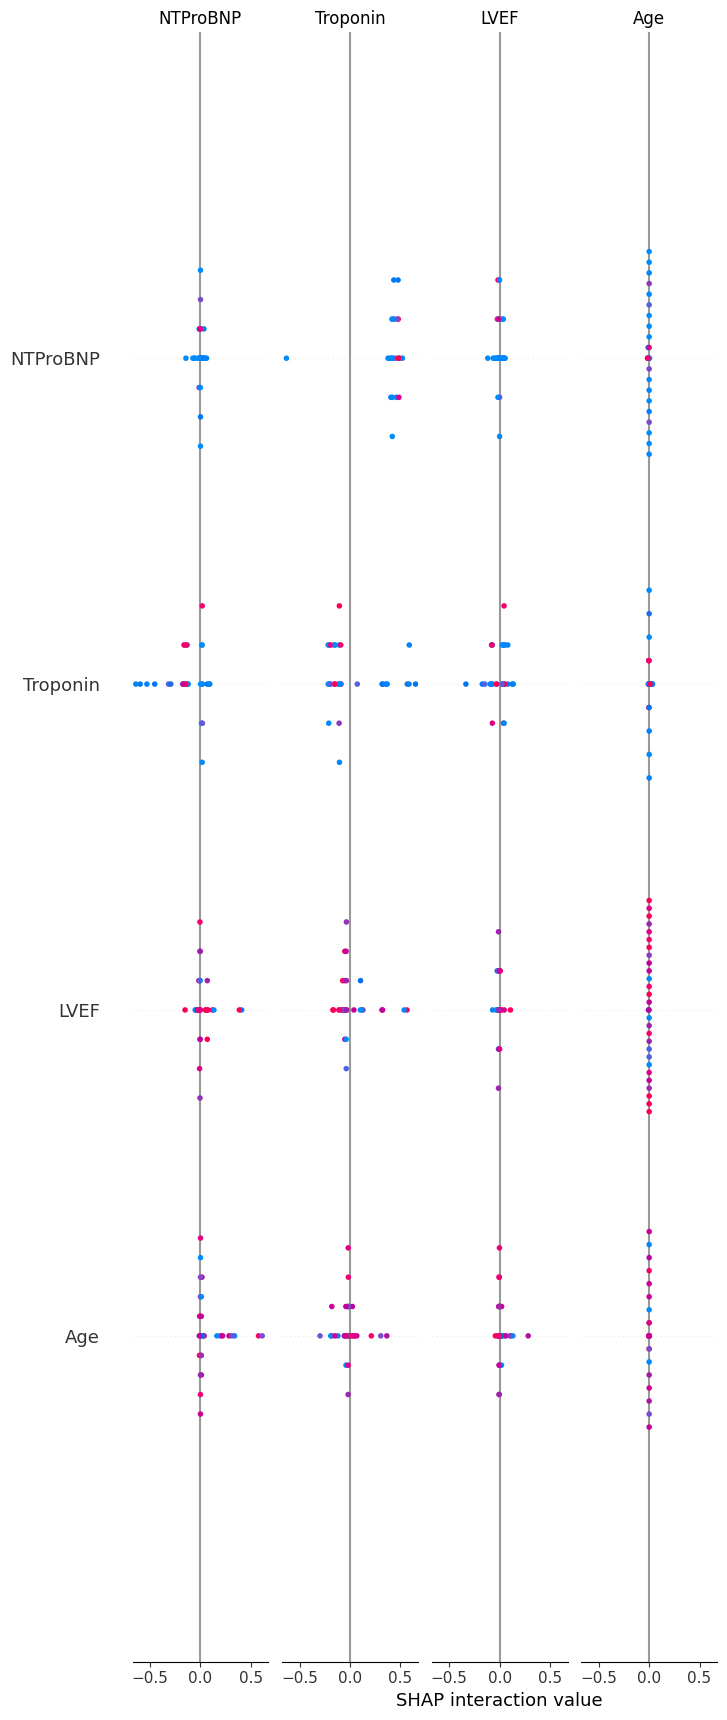

<Figure size 640x480 with 0 Axes>


--- Plot 2: Individual Patient Report (Waterfall) ---
Generating explanation for Patient ID: 13
  -> Actual Risk:     Very High Risk (Acute Cardiac Event) (Score: 3)
  -> Predicted Risk:  Very High Risk (Acute Cardiac Event) (Score: 3)

This Waterfall plot shows *why* the model predicted this outcome.
Red arrows push the prediction UP, Blue arrows push it DOWN.


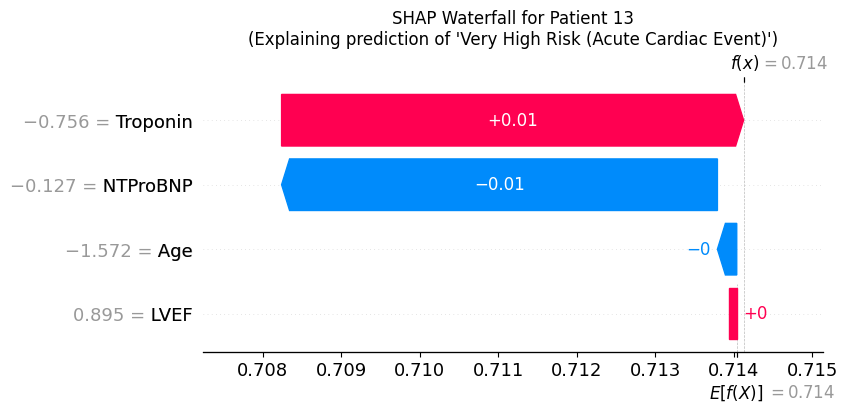

In [ ]:
import shap
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os

# --- 1. CONFIGURATION (Must match your training script) ---
MODEL_FILE = "best_prognostic_model.pkl"
DATA_FILE = "combined_radiomics_features.csv"
LABEL_COL = "Risk_Score"
PATIENT_ID_COL = "PatientID"
CATEGORY_COL = "Risk_Category"
TEST_SIZE = 0.20
RANDOM_STATE = 42

print(f"🔹 Loading model from {MODEL_FILE} and data from {DATA_FILE}...")

# --- 2. LOAD MODEL AND DATA ---
if not (os.path.exists(MODEL_FILE) and os.path.exists(DATA_FILE)):
    print(f"❌ ERROR: Could not find {MODEL_FILE} or {DATA_FILE}.")
    print("Please ensure the training script has been run and the files are present.")
else:
    try:
        # Load the assets saved from your XGBoost training script
        assets = joblib.load(MODEL_FILE)
        model = assets['model']
        scaler = assets['scaler']
        label_mapping = assets['label_mapping'] # {0: 0, 1: 1, 2: 2, 3: 3}

        # Load the raw data
        df = pd.read_csv(DATA_FILE)

        # --- Get Class Names (from your original data processing) ---
        # We re-create the mapping of {0: 'Low Risk', 1: 'Moderate', ...}
        # This is more robust than hard-coding it.
        category_map_df = df.drop_duplicates(subset=[LABEL_COL]).sort_values(LABEL_COL)
        # Use the integer keys from the model's mapping to get the string names
        class_names = [category_map_df[category_map_df[LABEL_COL] == label_mapping[k]][CATEGORY_COL].values[0] for k in sorted(label_mapping.keys())]

        print(f"✅ Model, scaler, and data loaded.")
        print(f"   Found Class Names: {class_names}")

        # --- 3. RECREATE THE *EXACT* TRAIN AND TEST SETS ---
        # This is critical for SHAP to work correctly
        drop_cols = [PATIENT_ID_COL, CATEGORY_COL, 'Reasoning', LABEL_COL]
        X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

        y_raw = df[LABEL_COL].copy()
        le = LabelEncoder()
        y = le.fit_transform(y_raw) # y will be [0, 1, 2, 3]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
        )

        # Scale the data *exactly* as the model expects
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert to DataFrames for nice feature names in plots
        X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
        X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

        print(f"✅ Recreated scaled train/test sets. Test set shape: {X_test_scaled_df.shape}")

        # --- 4. CALCULATE SHAP VALUES ---
        print("🔹 Calculating SHAP values for the test set...")

        # Use KernelExplainer. It's a great all-purpose explainer.
        # We give it the model's prediction function and a "background" dataset
        # Using a summary of the training data (kmeans) is best practice.
        background_data = shap.kmeans(X_train_scaled_df, 10) # 10 summary clusters

        explainer = shap.KernelExplainer(model.predict_proba, background_data)

        # Calculate SHAP values for the test set
        # This can take a moment
        shap_values = explainer.shap_values(X_test_scaled_df)

        print("✅ SHAP values calculated.")

        # --- 5. PLOT 1: GLOBAL FEATURE IMPORTANCE (Beeswarm) ---
        print("\n--- Plot 1: Global Feature Impact (SHAP Summary) ---")
        print("This plot shows the 20 most important features. Red dots are high feature values, blue are low.")
        print("A dot's position on the X-axis shows its impact on the model's prediction.")

        plt.figure()
        shap.summary_plot(shap_values, X_test_scaled_df, class_names=class_names, max_display=20, plot_type="dot")
        plt.tight_layout()
        plt.show()

        # --- 6. PLOT 2: INDIVIDUAL PATIENT REPORT (Waterfall) ---
        print("\n--- Plot 2: Individual Patient Report (Waterfall) ---")

        # Pick the first patient in the test set to explain
        patient_index = 0
        patient_id = df.loc[X_test.index[patient_index], PATIENT_ID_COL]

        actual_risk_score = y_test[patient_index]
        actual_risk_name = class_names[actual_risk_score]

        # Get the model's prediction for this one patient
        predicted_probs = model.predict_proba(X_test_scaled_df.iloc[[patient_index]])[0]
        predicted_risk_score = np.argmax(predicted_probs)
        predicted_risk_name = class_names[predicted_risk_score]

        print(f"Generating explanation for Patient ID: {patient_id}")
        print(f"  -> Actual Risk:     {actual_risk_name} (Score: {actual_risk_score})")
        print(f"  -> Predicted Risk:  {predicted_risk_name} (Score: {predicted_risk_score})")
        print("\nThis Waterfall plot shows *why* the model predicted this outcome.")
        print("Red arrows push the prediction UP, Blue arrows push it DOWN.")

        # Create the SHAP explanation object for the waterfall plot
        # We explain the prediction for the class that was *predicted*
        shap_exp_waterfall = shap.Explanation(
            values=shap_values[predicted_risk_score][patient_index],
            base_values=explainer.expected_value[predicted_risk_score],
            data=X_test_scaled_df.iloc[patient_index].values,
            feature_names=X.columns
        )

        plt.figure()
        plt.title(f"SHAP Waterfall for Patient {patient_id}\n(Explaining prediction of '{predicted_risk_name}')")
        shap.waterfall_plot(shap_exp_waterfall, max_display=20, show=True)
        # Note: 'show=True' is needed for waterfall_plot to display correctly

    except Exception as e:
        print(f"❌ An error occurred during the SHAP process: {e}")

In [ ]:
import os
import numpy as np
import nibabel as nib
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import warnings

# Suppress TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow C++ logs

# ---------------------------
# Helper Functions
# ---------------------------
def load_nii(path):
    """Loads NIfTI file and returns data array."""
    try:
        nii = nib.load(path)
        return nii.get_fdata()
    except FileNotFoundError:
        print(f"  [Helper] File not found: {path}")
        return None
    except Exception as e:
        print(f"  [Helper] Error loading {path}: {e}")
        return None

def normalize_img(img):
    """Normalizes a single image slice to [0, 1]."""
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val > 1e-8:
        return (img - min_val) / (max_val - min_val)
    return img - min_val # Avoid division by zero if max == min

def preprocess_volume(img, mask=None, target_size=(128,128)):
    """Preprocesses a 3D volume into a stack of 2D slices."""
    slices, masks = [], []
    if img is None:
        return np.array([]), np.array([]) if mask is not None else np.array([])

    for i in range(img.shape[2]):
        slice_img = normalize_img(img[:,:,i])
        slice_img = tf.image.resize(slice_img[...,None], target_size).numpy()
        slices.append(slice_img)

        if mask is not None:
            slice_mask = mask[:,:,i]
            slice_mask[slice_mask > 2] = 0 # Set values greater than 2 to 0
            slice_mask = tf.image.resize(slice_mask[...,None], target_size, method="nearest").numpy()
            masks.append(slice_mask)

    if mask is not None:
        return np.array(slices), np.array(masks)
    return np.array(slices)

# ---------------------------
# Multi-class U-Net Model
# ---------------------------
def unet_multiclass(input_shape=(128,128,1), num_classes=3):
    """Defines the 2D U-Net architecture."""
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='c1_conv1')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='c1_conv2')(c1)
    p1 = layers.MaxPooling2D((2,2), name='p1')(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='c2_conv1')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='c2_conv2')(c2)
    p2 = layers.MaxPooling2D((2,2), name='p2')(c2)

    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='c3_conv1')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='c3_conv2')(c3)
    p3 = layers.MaxPooling2D((2,2), name='p3')(c3)

    # Bottleneck
    bn = layers.Conv2D(128, (3,3), activation='relu', padding='same', name='bn_conv1')(p3)
    bn = layers.Conv2D(128, (3,3), activation='relu', padding='same', name='bn_conv2')(bn)

    # Decoder
    u1 = layers.UpSampling2D((2,2), name='u1')(bn)
    u1_concat = layers.concatenate([u1, c3], name='u1_concat')
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='c4_conv1')(u1_concat)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same', name='c4_conv2')(c4)

    u2 = layers.UpSampling2D((2,2), name='u2')(c4)
    u2_concat = layers.concatenate([u2, c2], name='u2_concat')
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='c5_conv1')(u2_concat)
    c5 = layers.Conv2D(32, (3,3), activation='relu', padding='same', name='c5_conv2')(c5)

    u3 = layers.UpSampling2D((2,2), name='u3')(c5)
    u3_concat = layers.concatenate([u3, c1], name='u3_concat')
    c6 = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='c6_conv1')(u3_concat)
    # This is the last conv layer before the final output, our target for Grad-CAM
    c6_final = layers.Conv2D(16, (3,3), activation='relu', padding='same', name='c6_conv2_gradcam_target')(c6)

    outputs = layers.Conv2D(num_classes, (1,1), activation='softmax', name='final_output_layer')(c6_final)

    model = models.Model(inputs, outputs)
    return model

# ---------------------------
# Load Training Data
# ---------------------------
print("🔹 [1/4] Loading training data...")
TRAIN_DATA_PATH = '/content/dataset/emidec-data/emidec-dataset-1.0.1/Data'

if not os.path.exists(TRAIN_DATA_PATH):
    print(f"❌ ERROR: Dataset path not found: {TRAIN_DATA_PATH}")
    print("Please ensure 'emidec_data.zip' is uploaded and extracted.")
else:
    img_paths = sorted(glob(os.path.join(TRAIN_DATA_PATH, "Case_*", "Images", "*.nii.gz")))
    mask_paths = sorted(glob(os.path.join(TRAIN_DATA_PATH, "Case_*", "Contours", "*.nii.gz")))

    X, Y = [], []
    for img_p, mask_p in zip(img_paths, mask_paths):
        img = load_nii(img_p)
        mask = load_nii(mask_p)
        if img is not None and mask is not None:
            xs, ys = preprocess_volume(img, mask)
            if xs.size > 0 and ys.size > 0:
                X.append(xs); Y.append(ys)

    if not X or not Y:
        print("❌ ERROR: No data was loaded. Check file paths and helper functions.")
    else:
        X = np.concatenate(X, axis=0)
        Y = np.concatenate(Y, axis=0)
        print(f"✅ [1/4] Data loaded. Shapes: X={X.shape}, Y={Y.shape}")

        Y = tf.keras.utils.to_categorical(Y, num_classes=3)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
        print("✅ [2/4] Data split and encoded.")

        # ---------------------------
        # Train Model
        # ---------------------------
        print("🔹 [3/4] Building and compiling U-Net...")
        model = unet_multiclass()
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        print("🔹 [3/4] Starting model training (40 epochs)...")
        history = model.fit(X_train, Y_train, epochs=40, batch_size=16,
                            validation_data=(X_val, Y_val), verbose=1)

        # ---------------------------
        # Save Model
        # ---------------------------
        MODEL_SAVE_PATH = "/content/unet_multiclass.h5"
        model.save(MODEL_SAVE_PATH)
        print(f"✅ [4/4] Model successfully trained and saved to {MODEL_SAVE_PATH}")

🔹 [1/4] Loading training data...
✅ [1/4] Data loaded. Shapes: X=(708, 128, 128, 1), Y=(708, 128, 128, 1)
✅ [2/4] Data split and encoded.
🔹 [3/4] Building and compiling U-Net...
🔹 [3/4] Starting model training (40 epochs)...
Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.8393 - loss: 0.5201 - val_accuracy: 0.9709 - val_loss: 0.1255
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9724 - loss: 0.1018 - val_accuracy: 0.9709 - val_loss: 0.0958
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.9719 - loss: 0.0910 - val_accuracy: 0.9709 - val_loss: 0.0829
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9724 - loss: 0.0802 - val_accuracy: 0.9709 - val_loss: 0.0777
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9729 - loss: 0.0731 - val_accuracy: 0.9709 - val_loss: 0.0722
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9727 - loss: 0.0671 - val_accuracy: 0.9709 - val_loss: 0.0665
Epoch 7/40
36/36 

✅ [4/4] Model successfully trained and saved to /content/unet_multiclass.h5


In [ ]:
import tensorflow as tf
import os

MODEL_PATH = "/content/unet_multiclass.h5"

if not os.path.exists(MODEL_PATH):
    print(f"❌ Error: Model file still not found at {MODEL_PATH}")
else:
    try:
        model = tf.keras.models.load_model(MODEL_PATH, compile=False)
        print(f"✅ Model {MODEL_PATH} loaded successfully.")
        print("\n--- Model Summary ---")
        model.summary()
        print("\n--- End of Summary ---")

        print("\n✅ Please copy and paste this entire summary in our chat.")
        print("I have already named the target layer 'c6_conv2_gradcam_target',")
        print("but pasting the summary will confirm it's correct.")

    except Exception as e:
        print(f"❌ An error occurred while loading the model: {e}")

✅ Model /content/unet_multiclass.h5 loaded successfully.

--- Model Summary ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c1_conv1 (Conv2D)   │ (None, 128, 128,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c1_conv2 (Conv2D)   │ (None, 128, 128,  │      2,320 │ c1_conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p1 (MaxPooling2D)   │ (None, 64, 64,    │          0 │ c1_conv2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2_conv1 (Conv2D)   │ (None, 64, 64,    │      4,640 │ p1[0][0]          │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c2_conv2 (Conv2D)   │ (None, 64, 64,    │      9,248 │ c2_conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p2 (MaxPooling2D)   │ (None, 32, 32,    │          0 │ c2_conv2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c3_conv1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ p2[0][0]          │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c3_conv2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ c3_conv1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p3 (MaxPooling2D)   │ (None, 16, 16,    │          0 │ c3_conv2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1 (Conv2D)   │ (None, 16, 16,    │     73,856 │ p3[0][0]          │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv2 (Conv2D)   │ (None, 16, 16,    │    147,584 │ bn_conv1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u1 (UpSampling2D)   │ (None, 32, 32,    │          0 │ bn_conv2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u1_concat           │ (None, 32, 32,    │          0 │ u1[0][0],         │
│ (Concatenate)       │ 192)              │            │ c3_conv2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c4_conv1 (Conv2D)   │ (None, 32, 32,    │    110,656 │ u1_concat[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ c4_conv2 (Conv2D)   │ (None, 32, 32,    │     36,928 │ c4_conv1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ u2 (UpSampling2D)   │ (None, 64, 64,    │          0 │ c4_conv2[0][0]  

 Total params: 487,043 (1.86 MB)

 Trainable params: 487,043 (1.86 MB)

 Non-trainable params: 0 (0.00 B)


--- End of Summary ---

✅ Please copy and paste this entire summary in our chat.
I have already named the target layer 'c6_conv2_gradcam_target',
but pasting the summary will confirm it's correct.


🔹 [1/3] Configuration set. Processing 10 patients for Myocardium (Class 2).
🔹 [2/3] Loading trained U-Net model...
✅ [2/3] Model '/content/unet_multiclass.h5' loaded.
🔹 [3/3] Building Grad-CAM model targeting layer: c6_conv2_gradcam_target...
✅ [3/3] Grad-CAM model built.

STARTING GRAD-CAM PROCESSING FOR 10 PATIENTS


--- Processing Patient 1/10 (ID: 101) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_101/Images/Case_101.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 6
  Generating heatmap...
  Plotting results for Patient 101...


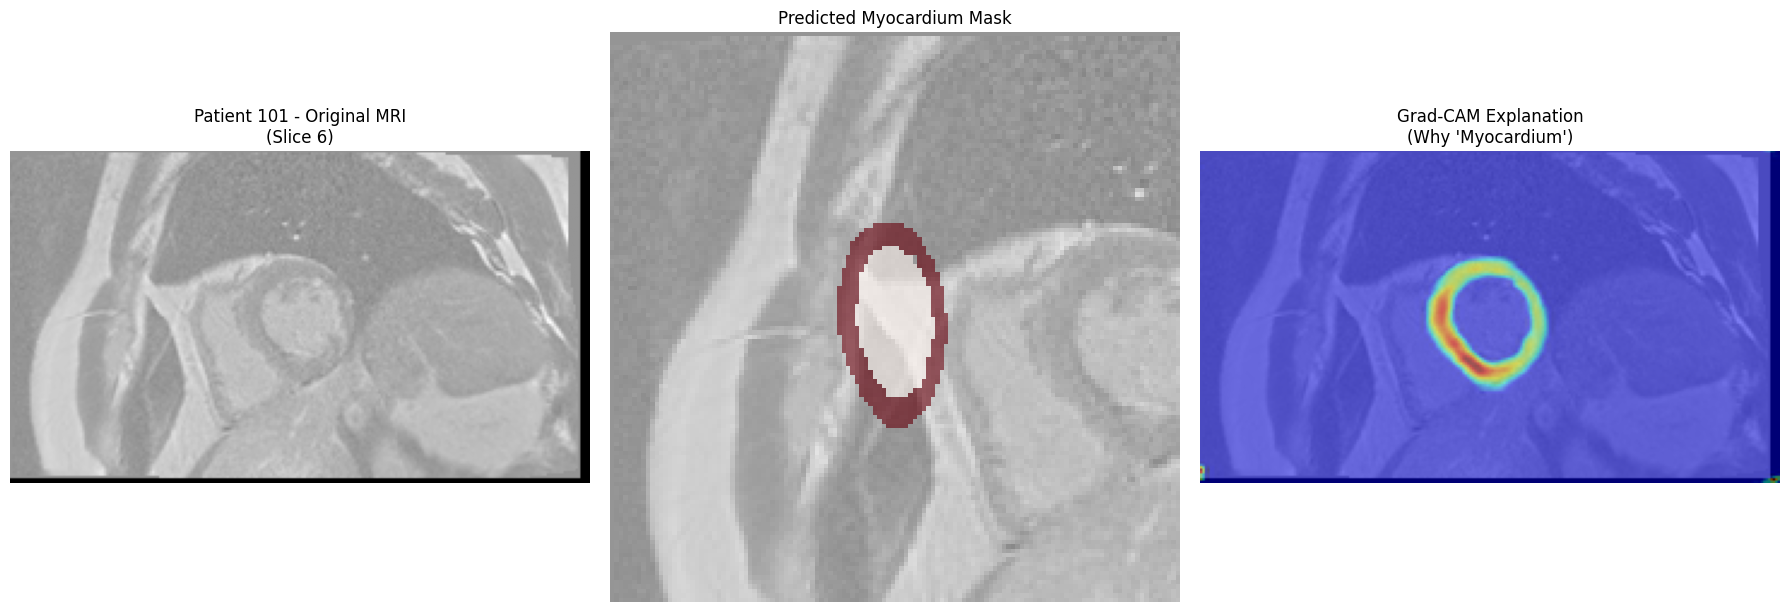


--- Processing Patient 2/10 (ID: 102) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_102/Images/Case_102.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 5
  Generating heatmap...
  Plotting results for Patient 102...


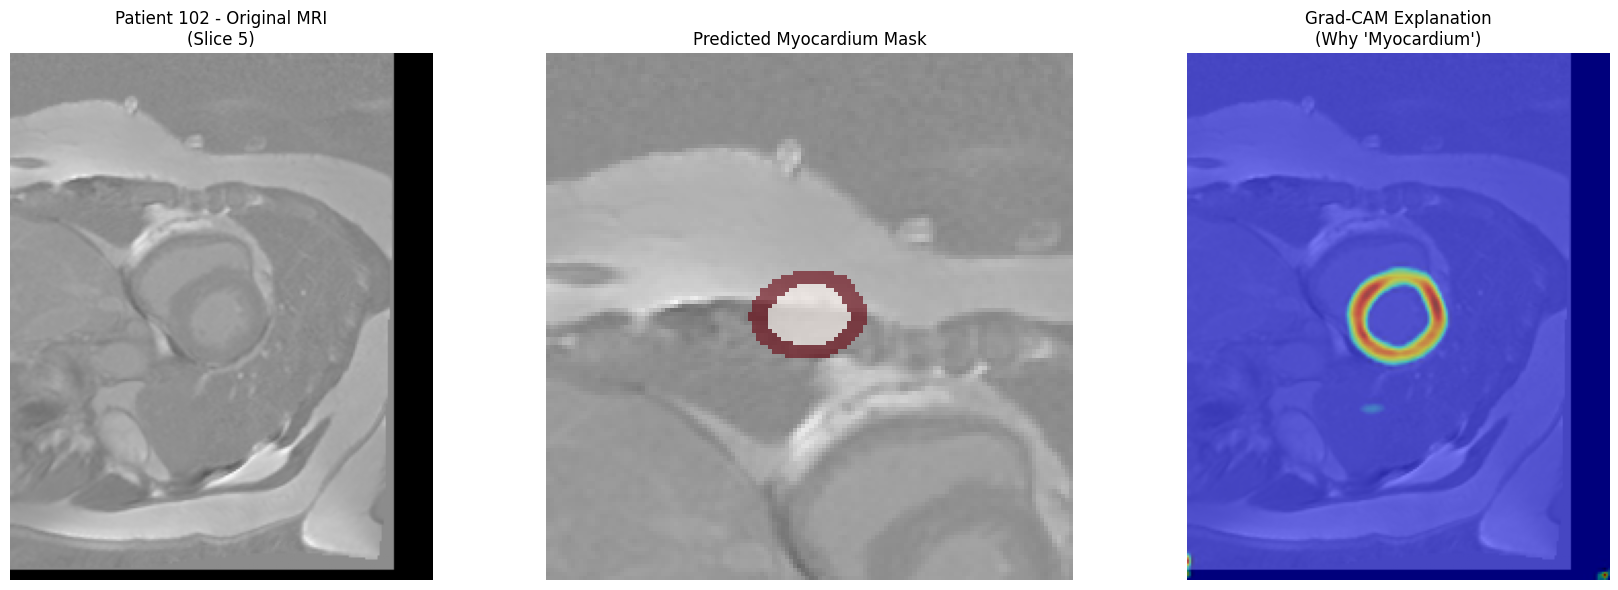


--- Processing Patient 3/10 (ID: 103) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_103/Images/Case_103.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 4
  Generating heatmap...
  Plotting results for Patient 103...


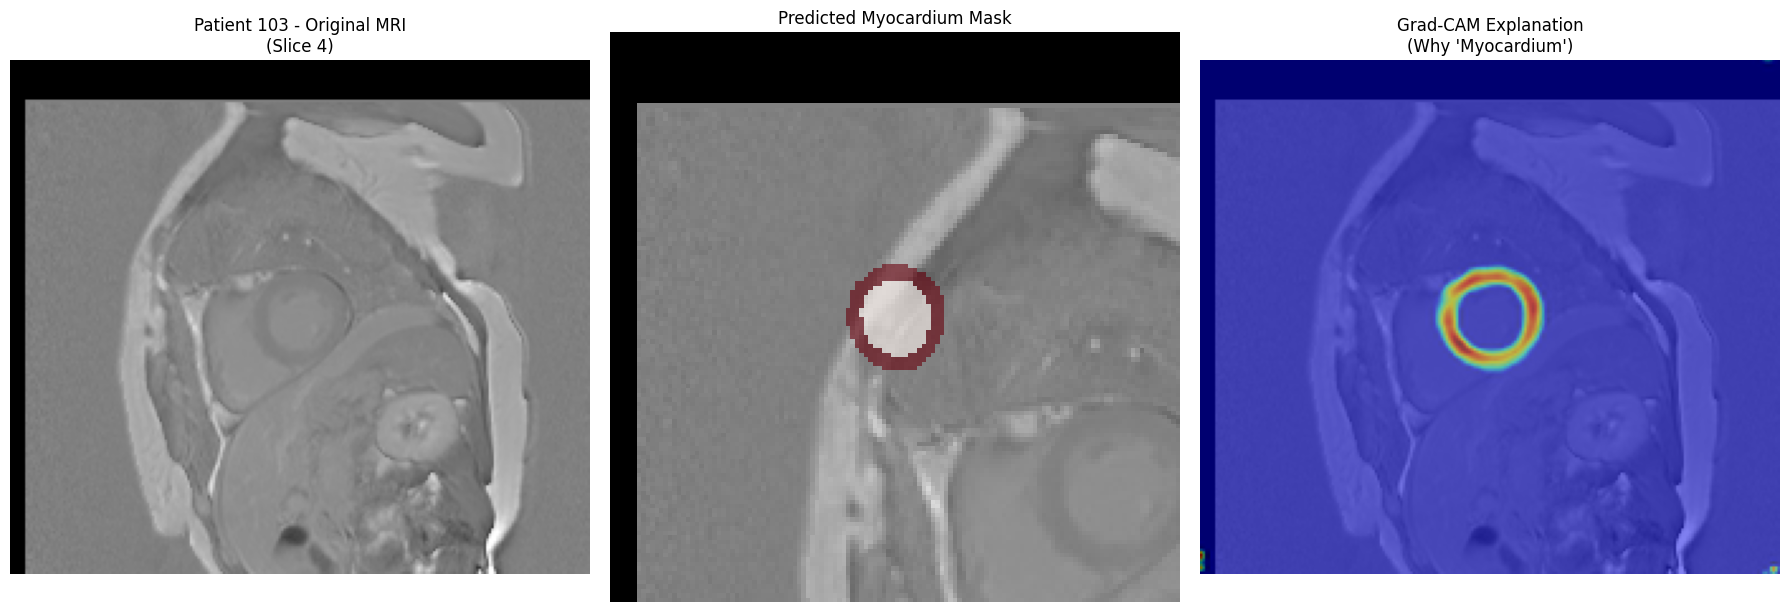


--- Processing Patient 4/10 (ID: 104) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_104/Images/Case_104.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 5
  Generating heatmap...
  Plotting results for Patient 104...


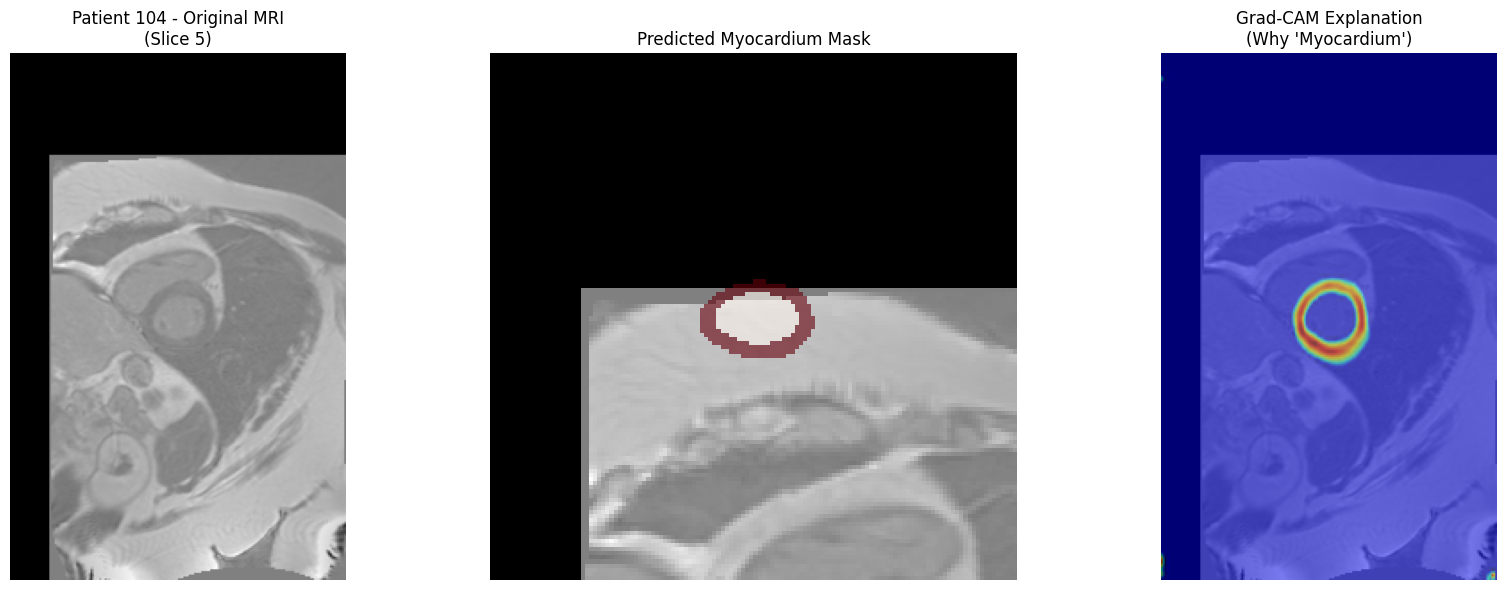


--- Processing Patient 5/10 (ID: 105) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_105/Images/Case_105.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 8
  Generating heatmap...
  Plotting results for Patient 105...


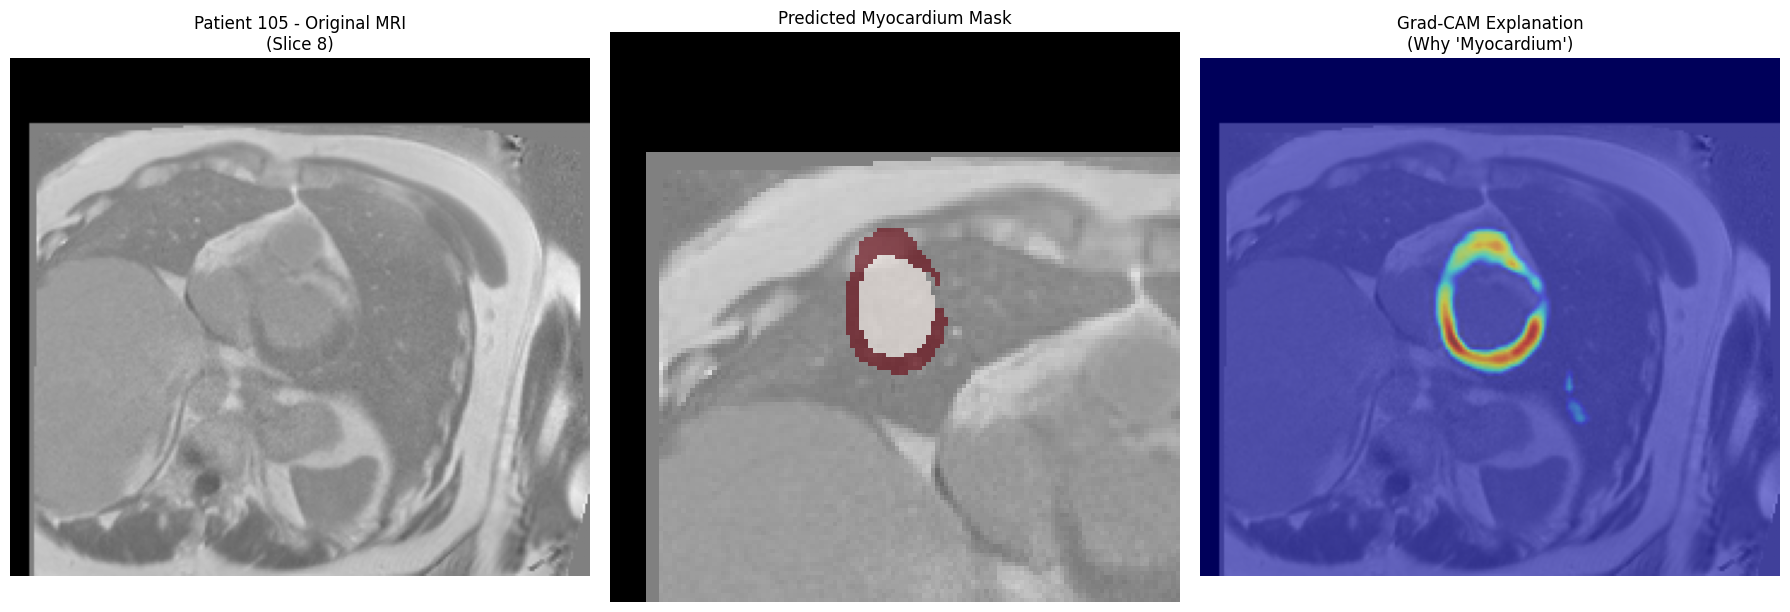


--- Processing Patient 6/10 (ID: 106) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_106/Images/Case_106.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 6
  Generating heatmap...
  Plotting results for Patient 106...


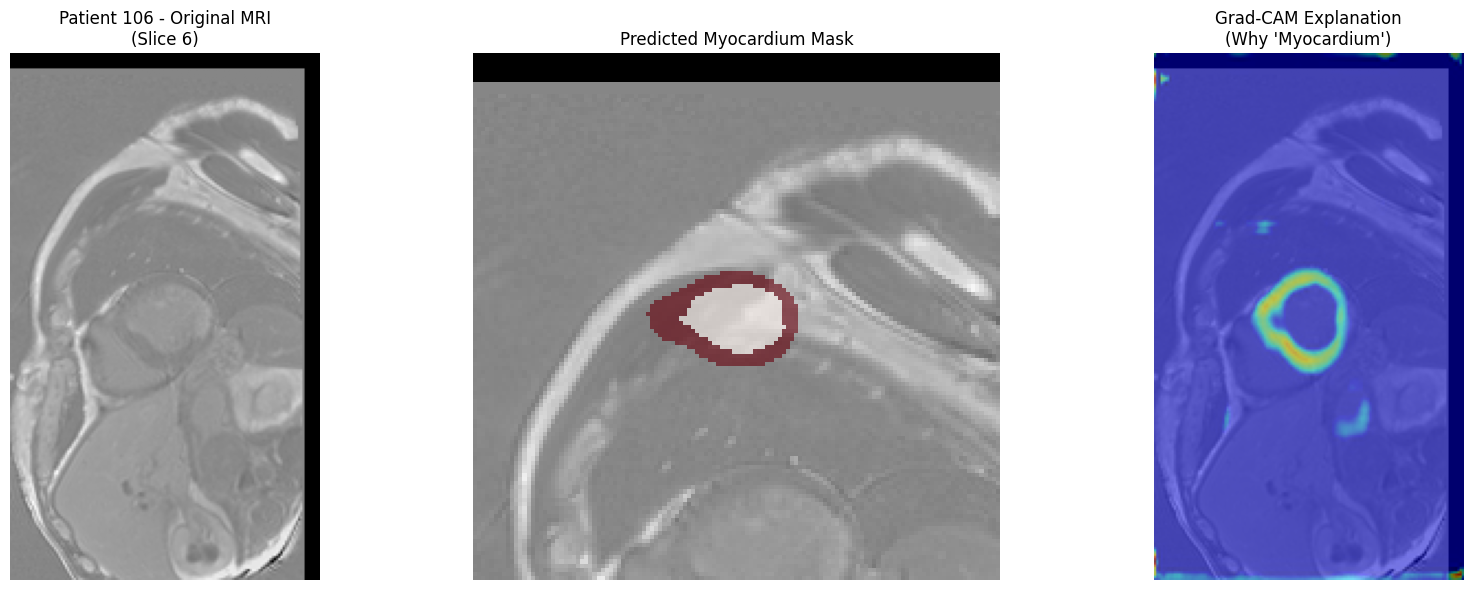


--- Processing Patient 7/10 (ID: 107) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_107/Images/Case_107.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 6
  Generating heatmap...
  Plotting results for Patient 107...


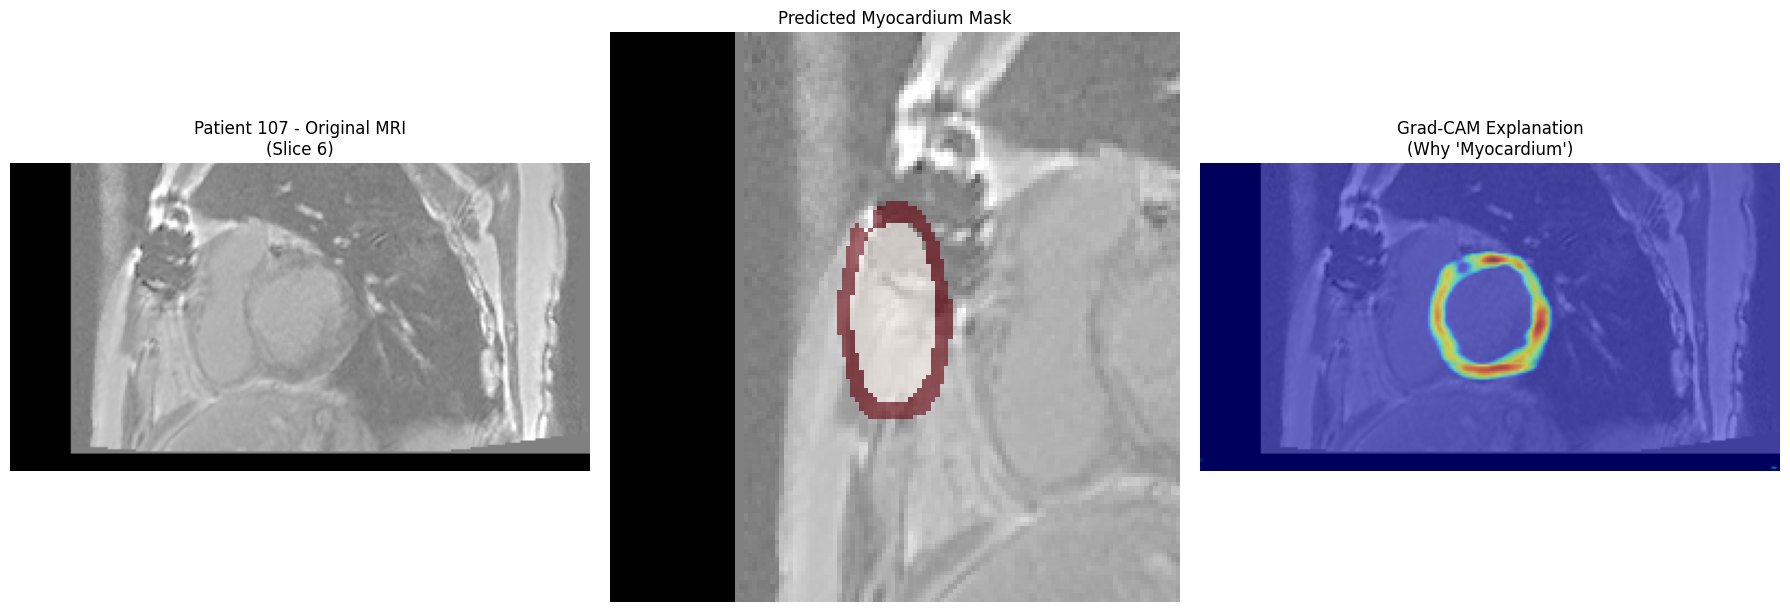


--- Processing Patient 8/10 (ID: 108) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_108/Images/Case_108.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 5
  Generating heatmap...
  Plotting results for Patient 108...


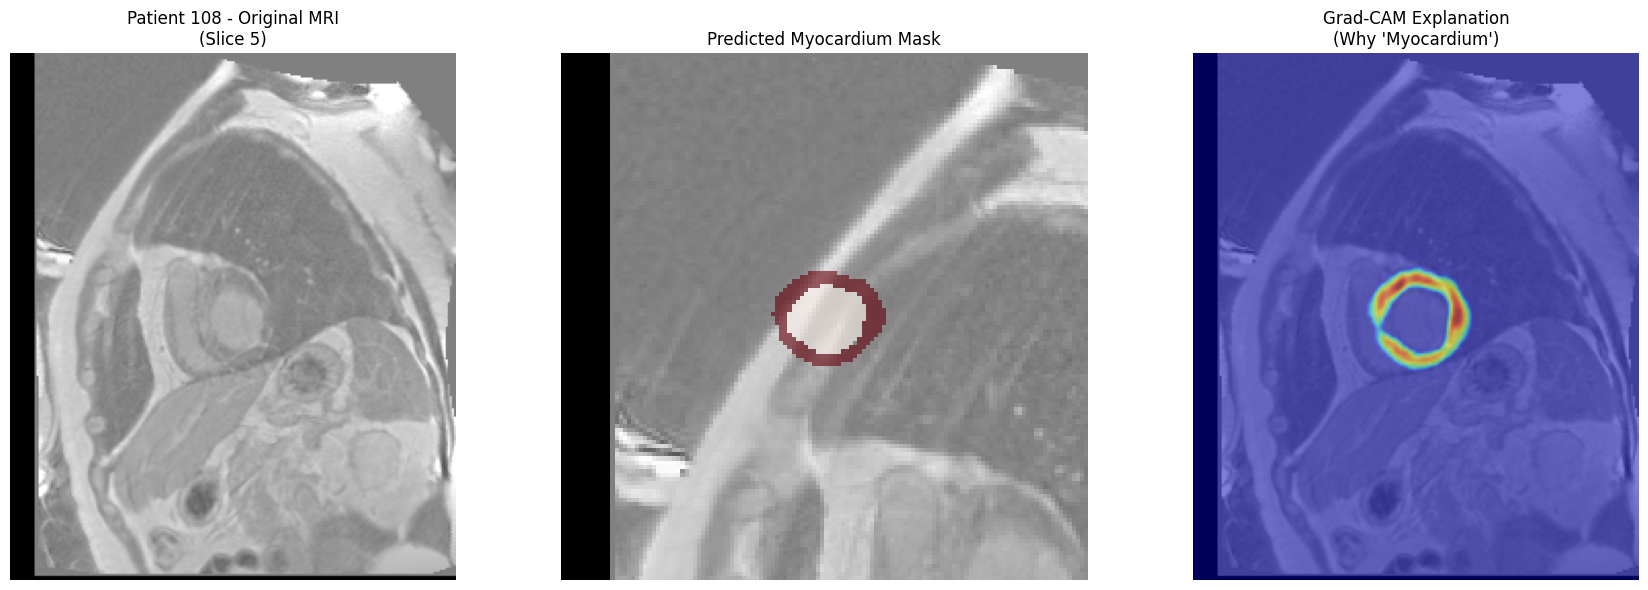


--- Processing Patient 9/10 (ID: 109) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_109/Images/Case_109.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 5
  Generating heatmap...
  Plotting results for Patient 109...


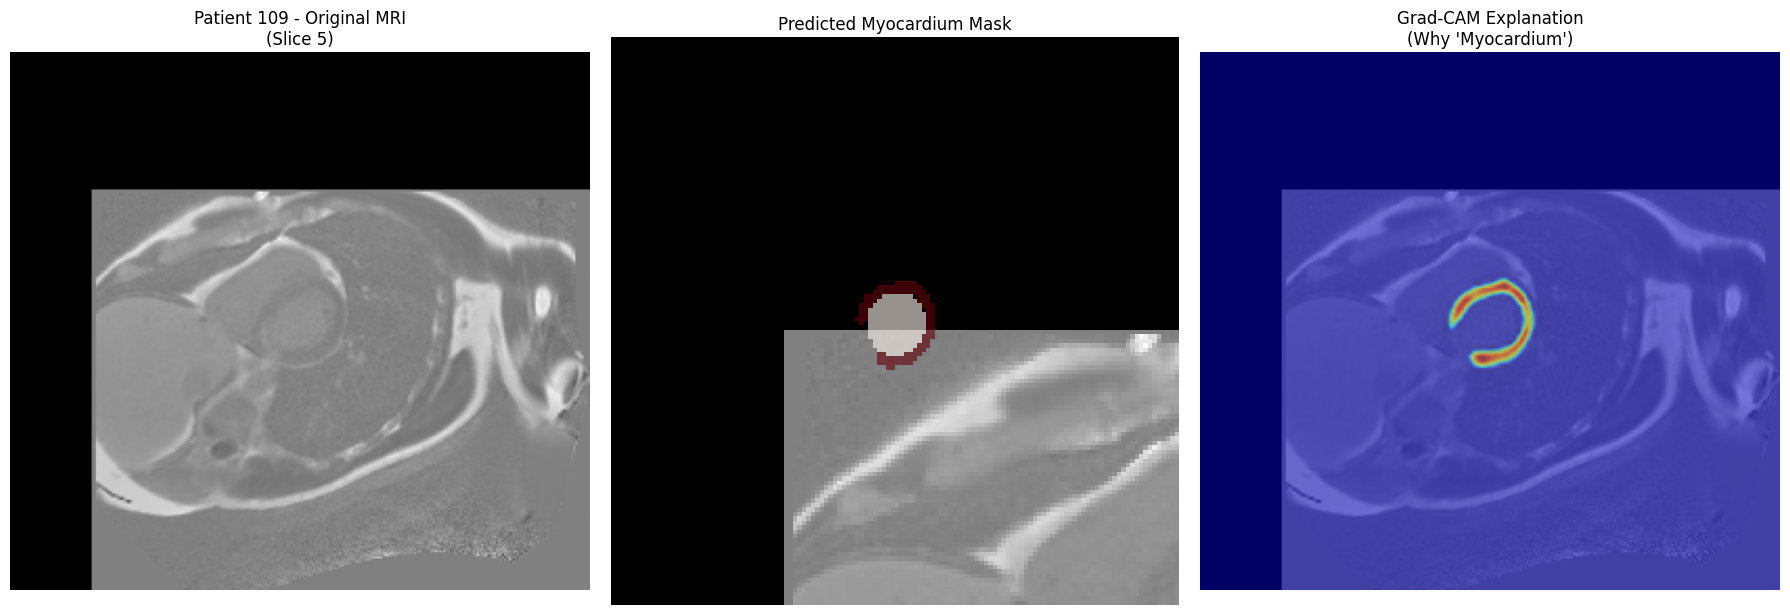


--- Processing Patient 10/10 (ID: 110) ---
  Loading MRI from /content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data/Case_110/Images/Case_110.nii.gz...
  Predicting all slices to find best one...
  Best slice found: Index 7
  Generating heatmap...
  Plotting results for Patient 110...


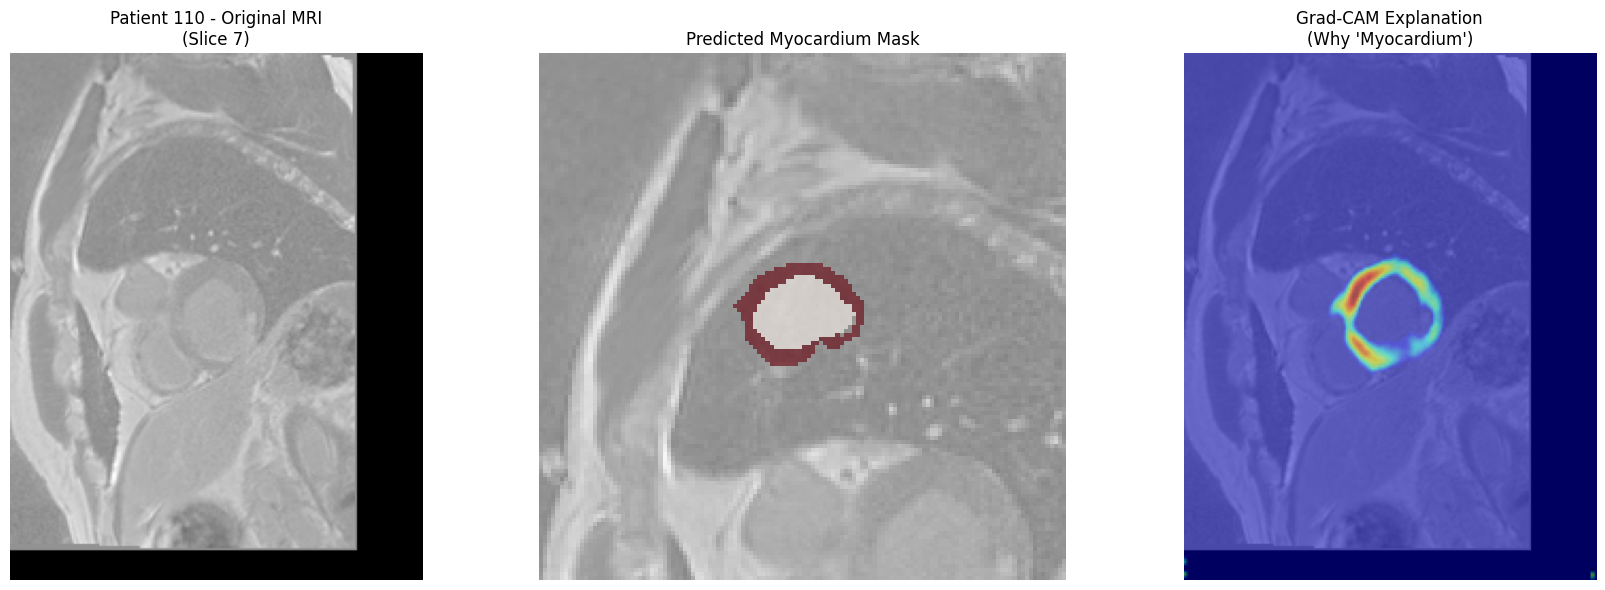


✅ All patients processed.


In [ ]:
import tensorflow as tf
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from glob import glob
from scipy.ndimage import zoom

# ---------------------------
# 1. CONFIGURATION
# ---------------------------
MODEL_PATH = "/content/unet_multiclass.h5"
# --- UPDATED: List of 10 patients to process ---
TEST_PATIENT_IDS = ["101", "102", "103", "104", "105",
                  "106", "107", "108", "109", "110"]
# -----------------------------------------------
TARGET_CLASS_ID = 2      # 0=Background, 1=LV Cavity, 2=Myocardium
GRAD_CAM_LAYER = "c6_conv2_gradcam_target"
IMG_SIZE = (128, 128)
BASE_TEST_DATA_PATH = "/content/dataset/emidec-data/emidec-segmentation-testset-1.0.0/Test Data"

print(f"🔹 [1/3] Configuration set. Processing {len(TEST_PATIENT_IDS)} patients for Myocardium (Class {TARGET_CLASS_ID}).")

# ---------------------------
# 2. HELPER FUNCTIONS (No changes)
# ---------------------------
def load_nii(path):
    try:
        nii = nib.load(path)
        return nii.get_fdata(), nii.affine, nii.header
    except Exception as e:
        # We will handle this error inside the loop
        raise e

def normalize_slice(img):
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val > 1e-8:
        return (img - min_val) / (max_val - min_val)
    return img - min_val

def preprocess_volume(img_volume, target_size=(128, 128)):
    slices = []
    for i in range(img_volume.shape[2]):
        slice_img = normalize_slice(img_volume[:, :, i])
        slice_resized = tf.image.resize(slice_img[..., None], target_size).numpy()
        slices.append(slice_resized)
    return np.array(slices)

# ---------------------------
# 3. LOAD MODEL & BUILD GRAD-CAM MODEL (ONCE)
# ---------------------------
if not os.path.exists(MODEL_PATH):
    print(f"❌ Model file not found at {MODEL_PATH}. Please re-run the U-Net training script.")
else:
    print("🔹 [2/3] Loading trained U-Net model...")
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
    print(f"✅ [2/3] Model '{MODEL_PATH}' loaded.")

    print(f"🔹 [3/3] Building Grad-CAM model targeting layer: {GRAD_CAM_LAYER}...")
    try:
        grad_model = tf.keras.models.Model(
            model.inputs,
            [model.get_layer(GRAD_CAM_LAYER).output, model.output]
        )
        print("✅ [3/3] Grad-CAM model built.")
    except Exception as e:
        print(f"❌ Failed to build Grad-CAM model. Error: {e}")
        # If this fails, we can't proceed.
        model = None # Set model to None to skip the loop

    # ---------------------------
    # 4. LOOP AND PROCESS ALL PATIENTS
    # ---------------------------
    if model is not None:
        print("\n" + "="*50)
        print(f"STARTING GRAD-CAM PROCESSING FOR {len(TEST_PATIENT_IDS)} PATIENTS")
        print("="*50 + "\n")

        for i, patient_id in enumerate(TEST_PATIENT_IDS):
            print(f"\n--- Processing Patient {i+1}/{len(TEST_PATIENT_IDS)} (ID: {patient_id}) ---")

            try:
                # --- Step 4.1: Load Patient MRI ---
                mri_path = f"{BASE_TEST_DATA_PATH}/Case_{patient_id}/Images/Case_{patient_id}.nii.gz"
                if not os.path.exists(mri_path):
                    print(f"  ⚠️ WARNING: File not found at {mri_path}. Skipping patient.")
                    continue

                print(f"  Loading MRI from {mri_path}...")
                mri_volume, affine, header = load_nii(mri_path)
                if mri_volume is None:
                    continue

                original_shape = mri_volume.shape

                # --- Step 4.2: Preprocess & Find Best Slice ---
                print("  Predicting all slices to find best one...")
                processed_volume = preprocess_volume(mri_volume, IMG_SIZE)
                predictions = model.predict(processed_volume, verbose=0)
                predicted_masks = np.argmax(predictions, axis=-1)

                slice_scores = np.sum(predicted_masks == TARGET_CLASS_ID, axis=(1, 2))
                best_slice_index = np.argmax(slice_scores)

                original_slice = mri_volume[:, :, best_slice_index]
                processed_slice = processed_volume[best_slice_index:best_slice_index+1]
                predicted_mask_slice = predicted_masks[best_slice_index]

                print(f"  Best slice found: Index {best_slice_index}")

                # --- Step 4.3: Generate Heatmap ---
                print("  Generating heatmap...")
                with tf.GradientTape() as tape:
                    conv_outputs, predictions_tape = grad_model(processed_slice)
                    loss = tf.reduce_mean(predictions_tape[:, :, :, TARGET_CLASS_ID])

                grads = tape.gradient(loss, conv_outputs)
                pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
                heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
                heatmap = tf.squeeze(heatmap).numpy()

                heatmap = np.maximum(heatmap, 0) # ReLU
                if np.max(heatmap) > 0:
                    heatmap /= np.max(heatmap)

                heatmap_resized = zoom(heatmap, (original_slice.shape[0]/IMG_SIZE[0],
                                                  original_slice.shape[1]/IMG_SIZE[1]))

                # --- Step 4.4: Visualize Results ---
                print(f"  Plotting results for Patient {patient_id}...")
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                plt.imshow(original_slice.T, cmap='gray')
                plt.title(f"Patient {patient_id} - Original MRI\n(Slice {best_slice_index})")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(original_slice.T, cmap='gray')
                mask_overlay = np.ma.masked_where(predicted_mask_slice.T == 0, predicted_mask_slice.T)
                plt.imshow(mask_overlay, cmap='Reds', alpha=0.6)
                plt.title("Predicted Myocardium Mask")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(original_slice.T, cmap='gray')
                plt.imshow(heatmap_resized.T, cmap='jet', alpha=0.5)
                plt.title(f"Grad-CAM Explanation\n(Why 'Myocardium')")
                plt.axis('off')

                plt.tight_layout()
                plt.show() # Display the plot for this patient

            except Exception as e:
                print(f"  ❌ An error occurred while processing Patient {patient_id}: {e}")
                continue # Move to the next patient

        print("\n" + "="*50)
        print("✅ All patients processed.")
        print("="*50)

In [ ]:
# ===========================================================
# Colab: Grad-CAM on EMIDEC — Process WHOLE DATASET ROOT
# Scans /content/dataset/emidec-data recursively for Case_* nii.gz
# ===========================================================
import tensorflow as tf
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os, re
from glob import glob
from scipy.ndimage import zoom

# ---------------------------
# 0) INTERACTIVE INPUTS
# ---------------------------
def ask_path(prompt, default=""):
    p = input(f"{prompt}\n[{default}] > ").strip()
    return p if p else default

def ask_text(prompt, default=""):
    t = input(f"{prompt}\n[{default}] > ").strip()
    return t if t else default

def ask_int(prompt, default):
    t = input(f"{prompt}\n[{default}] > ").strip()
    try:
        return int(t) if t else default
    except:
        print("Invalid integer; using default.")
        return default

print("🔹 Provide inputs (press Enter to accept defaults):")

MODEL_PATH = ask_path(
    "Full path to your trained U-Net model (.h5 or SavedModel folder)",
    "/content/unet_multiclass.h5"
)

# Fixed: whole dataset root
DATA_ROOT = "/content/dataset/emidec-data"
print(f"📂 Dataset root is fixed to: {DATA_ROOT}")

TARGET_CLASS_ID = ask_int(
    "Target class ID for Grad-CAM (0=Background, 1=LV Cavity, 2=Myocardium)",
    2
)

GRAD_CAM_LAYER = ask_text(
    "Name of the target Conv layer for Grad-CAM (leave blank to auto-detect last Conv2D)",
    ""
)

IMG_SIZE = (128, 128)
SAVE_FIGS = True
OUTPUT_DIR = "/content/gradcam_results"

print(f"\n✅ Inputs set:\n- MODEL_PATH: {MODEL_PATH}\n- DATA_ROOT: {DATA_ROOT}\n- CLASS: {TARGET_CLASS_ID}\n- LAYER: {GRAD_CAM_LAYER or '(auto-detect)'}\n- SAVE_FIGS: {SAVE_FIGS} -> {OUTPUT_DIR}\n")
print(f"🔹 [1/4] Configuration complete.")

# ---------------------------
# 1) HELPERS
# ---------------------------
def load_nii(path):
    nii = nib.load(path)
    return nii.get_fdata(), nii.affine, nii.header

def normalize_slice(img):
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val > 1e-8:
        return (img - min_val) / (max_val - min_val)
    return img - min_val

def preprocess_volume(img_volume, target_size=(128, 128)):
    slices = []
    for i in range(img_volume.shape[2]):
        slice_img = normalize_slice(img_volume[:, :, i])
        slice_resized = tf.image.resize(slice_img[..., None], target_size).numpy()
        slices.append(slice_resized)
    return np.array(slices)

def find_last_conv2d_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

def build_grad_model(model, layer_name):
    layer = model.get_layer(layer_name)
    return tf.keras.models.Model(model.inputs, [layer.output, model.output])

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def case_id_from_path(path):
    # Extract "Case_XXX" as ID
    m = re.search(r"(Case_\d+)", path)
    return m.group(1) if m else os.path.basename(os.path.dirname(os.path.dirname(path)))

# ---------------------------
# 2) LOAD MODEL & GRAD MODEL
# ---------------------------
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"❌ Model file/folder not found at {MODEL_PATH}")

print("🔹 [2/4] Loading trained U-Net model...")
try:
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
    print(f"✅ Model loaded from: {MODEL_PATH}")
except Exception as e:
    raise RuntimeError(f"❌ Failed to load model: {e}")

target_layer_name = GRAD_CAM_LAYER.strip()
if not target_layer_name:
    auto_layer = find_last_conv2d_layer(model)
    if auto_layer is None:
        raise RuntimeError("❌ Could not auto-detect a Conv2D layer. Please provide GRAD_CAM_LAYER manually.")
    target_layer_name = auto_layer
    print(f"ℹ️ Auto-detected Grad-CAM layer: {target_layer_name}")
else:
    try:
        _ = model.get_layer(target_layer_name)
    except:
        all_conv = [l.name for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]
        raise ValueError(f"❌ Layer '{target_layer_name}' not found. First few Conv2D layers: {all_conv[:10]}{' ...' if len(all_conv)>10 else ''}")

print(f"🔹 [3/4] Building Grad-CAM model targeting layer: {target_layer_name}...")
grad_model = build_grad_model(model, target_layer_name)
print("✅ Grad-CAM model built.")

# ---------------------------
# 3) SCAN WHOLE DATASET ROOT
# ---------------------------
# Find all nii.gz paths like .../Case_XXX/Images/Case_XXX.nii.gz under any split
pattern = os.path.join(DATA_ROOT, "**", "Case_*", "Images", "Case_*.nii.gz")
nii_paths = sorted(glob(pattern, recursive=True))

print(f"\n🔎 Found {len(nii_paths)} cases under {DATA_ROOT}.")
if len(nii_paths) == 0:
    print("⚠️ No NIfTI files found. Please check dataset structure.")
else:
    if SAVE_FIGS:
        ensure_dir(OUTPUT_DIR)

# ---------------------------
# 4) PROCESS ALL CASES
# ---------------------------
print("\n" + "="*60)
print(f"STARTING GRAD-CAM FOR {len(nii_paths)} CASES")
print("="*60 + "\n")

for idx, mri_path in enumerate(nii_paths, 1):
    case_id = case_id_from_path(mri_path)
    print(f"\n--- [{idx}/{len(nii_paths)}] Processing {case_id} ---")

    try:
        if not os.path.exists(mri_path):
            print(f"  ⚠️ Not found: {mri_path}. Skipping.")
            continue

        print(f"  Loading MRI: {mri_path}")
        mri_volume, affine, header = load_nii(mri_path)
        if mri_volume is None:
            print("  ⚠️ Empty volume. Skipping.")
            continue

        original_shape = mri_volume.shape

        # Predict whole volume to pick best slice
        print("  Predicting all slices to find best one...")
        processed_volume = preprocess_volume(mri_volume, IMG_SIZE)        # (n, 128,128,1)
        predictions = model.predict(processed_volume, verbose=0)          # (n, 128,128,C)
        predicted_masks = np.argmax(predictions, axis=-1)                 # (n, 128,128)

        slice_scores = np.sum(predicted_masks == TARGET_CLASS_ID, axis=(1, 2))
        best_slice_index = int(np.argmax(slice_scores))

        original_slice = mri_volume[:, :, best_slice_index]
        processed_slice = processed_volume[best_slice_index:best_slice_index+1]  # (1,128,128,1)
        predicted_mask_slice = predicted_masks[best_slice_index]

        print(f"  Best slice index: {best_slice_index}")

        # Grad-CAM
        print("  Generating heatmap...")
        with tf.GradientTape() as tape:
            conv_outputs, predictions_tape = grad_model(processed_slice)
            loss = tf.reduce_mean(predictions_tape[:, :, :, TARGET_CLASS_ID])

        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()  # (channels,)

        fmap = conv_outputs[0].numpy()                              # (h, w, channels)
        heatmap = np.tensordot(fmap, pooled_grads, axes=([2], [0])) # (h, w)
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) > 0:
            heatmap /= np.max(heatmap)

        heatmap_resized = zoom(
            heatmap,
            (original_slice.shape[0]/IMG_SIZE[0], original_slice.shape[1]/IMG_SIZE[1]),
            order=1
        )

        # Visualize
        print(f"  Plotting results for {case_id}...")
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(original_slice.T, cmap='gray')
        plt.title(f"{case_id} - Original MRI\n(Slice {best_slice_index})")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(original_slice.T, cmap='gray')
        mask_overlay = np.ma.masked_where(predicted_mask_slice.T == 0, predicted_mask_slice.T)
        plt.imshow(mask_overlay, cmap='Reds', alpha=0.6)
        plt.title("Predicted Mask (Myocardium in red)")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(original_slice.T, cmap='gray')
        plt.imshow(heatmap_resized.T, cmap='jet', alpha=0.5)
        plt.title("Grad-CAM Explanation")
        plt.axis('off')

        plt.tight_layout()
        if SAVE_FIGS:
            rel_dir = os.path.relpath(os.path.dirname(os.path.dirname(mri_path)), DATA_ROOT)  # split path containing Case_XXX
            out_dir = os.path.join(OUTPUT_DIR, rel_dir)
            ensure_dir(out_dir)
            out_path = os.path.join(out_dir, f"{case_id}_gradcam.png")
            plt.savefig(out_path, dpi=150, bbox_inches="tight")
            print(f"  💾 Saved: {out_path}")
            plt.close()
        else:
            plt.show()

    except Exception as e:
        print(f"  ❌ Error while processing {case_id}: {e}")
        continue

print("\n" + "="*60)
print("✅ All cases processed.")
print("="*60)


🔹 Provide inputs (press Enter to accept defaults):
Full path to your trained U-Net model (.h5 or SavedModel folder)
[/content/unet_multiclass.h5] > /content/unet_multiclass.h5
📂 Dataset root is fixed to: /content/dataset/emidec-data
Target class ID for Grad-CAM (0=Background, 1=LV Cavity, 2=Myocardium)
[2] > 2
Name of the target Conv layer for Grad-CAM (leave blank to auto-detect last Conv2D)
[] > 

✅ Inputs set:
- MODEL_PATH: /content/unet_multiclass.h5
- DATA_ROOT: /content/dataset/emidec-data
- CLASS: 2
- LAYER: (auto-detect)
- SAVE_FIGS: True -> /content/gradcam_results

🔹 [1/4] Configuration complete.
🔹 [2/4] Loading trained U-Net model...
✅ Model loaded from: /content/unet_multiclass.h5
ℹ️ Auto-detected Grad-CAM layer: final_output_layer
🔹 [3/4] Building Grad-CAM model targeting layer: final_output_layer...
✅ Grad-CAM model built.

🔎 Found 150 cases under /content/dataset/emidec-data.

STARTING GRAD-CAM FOR 150 CASES


--- [1/150] Processing Case_N006 ---
  Loading MRI: /content/

In [54]:
import shutil
from google.colab import files

# === USER INPUT ===
# Path to your uploaded folder inside Colab (e.g., from file upload or Drive)
folder_path = "/content/gradcam_results"   # 👈 change this to your folder name

# Name of the output ZIP file
zip_name = "gradcam_results.zip"

# === ZIP THE FOLDER ===
shutil.make_archive(zip_name.replace(".zip", ""), 'zip', folder_path)
print(f"✅ Folder '{folder_path}' has been zipped as '{zip_name}'")

# === OPTIONAL: DOWNLOAD THE ZIP FILE TO YOUR LOCAL MACHINE ===
files.download(zip_name)


✅ Folder '/content/gradcam_results' has been zipped as 'gradcam_results.zip'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>